## 0. Preamble

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")


In [2]:
import functools
import hashlib
import itertools
import json
import re
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
import pandas as pd
import seaborn as sns
import utils
from generation.graph import SATGraph
from history import History
from IPython.display import display
from tqdm.auto import tqdm

# sns.set_theme(style="darkgrid")
sns.set_theme(style="whitegrid", font_scale=1.3)  # type: ignore
# plt.rc('axes', labelsize=13)


In [3]:
def savefig(name: str, **kwargs):
    kwargs.setdefault("dpi", 200)
    kwargs.setdefault("bbox_inches", "tight")
    kwargs.setdefault("transparent", True)

    plt.savefig(name, **kwargs)
    plt.savefig(Path(name).with_suffix(".pdf"), **kwargs)


def load_history(
    directory: str,
    limit_episodes: int | None = None,
    load_step: bool = False,
    load_reruns: bool = False,
    load_eval: bool = False,
    base: str = "../lamgate/runs/SAGE",
) -> History:
    h = History.load(
        base + "/" + directory,
        load_step=load_step,
        load_reruns=load_reruns,
        load_eval=load_eval,
    )

    if limit_episodes is not None:
        h.episode = h.episode[
            h.episode.index.get_level_values("episode") < limit_episodes
        ]

    print("Loaded history from", directory.split("/")[-1])
    return h


def get_group(df: pd.DataFrame, group_name: str):
    prefix = group_name + "/"
    cols = [col for col in df.columns if col.startswith(prefix)]
    return df[cols].rename(columns=lambda name: name.removeprefix(prefix), copy=False)


def _template_size(x: str) -> int:
    t = utils.parse_template(x)
    if isinstance(t, list):
        return sum(len(clause) for clause in t)
    return t.sum()


def plot_metrics(
    hs: dict[str, History],
    metric: str = "time_cpu",
    legend_title="Experiment",
    window_size: int = 200,
    use_median: bool | None = None,
    saveto: str | None = None,
    title: str | None = None,
    move_legend: bool = False,
    new_figure: bool = True,
    evaluation: bool = False,
    template_size: int | None = None,
):
    if use_median is None:
        use_median = metric == "time_cpu"
    agg_fn = "median" if use_median else "mean"

    data = []
    for name, h in hs.items():
        episode = h.episode
        if template_size is not None:
            sizes = episode["template"].map(_template_size)
            episode = episode[sizes == template_size]
        metric_series = episode[f"metrics/{metric}"]
        metric_series.name = metric
        if evaluation:
            metric_series = metric_series.loc[metric_series.index.dropna()]
            m = metric_series.groupby("episode").agg(agg_fn)
        else:
            m = metric_series.xs(np.nan, level="eval_episode")
        if window_size > len(m):
            print(f"Warning: window_size is longer than data size ({name})")
        m = m.rolling(window_size).agg(agg_fn)
        m = m.reset_index()
        m[legend_title] = name
        data.append(m)
    data = pd.concat(data, ignore_index=True)

    if new_figure:
        plt.figure()
    sns.lineplot(x="episode", y=metric, hue=legend_title, data=data)
    metric_str = "time" if metric == "time_cpu" else metric
    mode_str = "median" if use_median else "avg."
    # ylabel = f"{agg_fn} eval {metric_str}" if evaluation else metric_str
    ylabel = metric_str
    if window_size > 1:
        ylabel = f"Moving {mode_str} of {ylabel} (window={window_size})"
    plt.ylabel(ylabel)
    plt.xlabel("Episode")
    plt.tight_layout()
    if move_legend:
        sns.move_legend(plt.gca(), loc="upper left", bbox_to_anchor=(1, 1))
    if saveto:
        savefig(saveto + ".png")
    if title:
        plt.title(title)


def filter_exps(
    exps: dict[str, History], pattern: str, update_keys: bool = True
) -> tuple[dict[str, History], dict[str, History]]:
    pos = {}
    neg = {}

    for k, v in exps.items():
        m = re.search(pattern, k)
        if m:
            if update_keys:
                k = k[: m.start()] + k[m.end() :]
            pos[k] = v
        else:
            neg[k] = v

    return pos, neg


## 1. Clause Sampling &mdash; Performance Considerations

In [4]:
s1 = {
    "base": load_history("s1 (base run)", limit_episodes=1500, load_step=True),
    "uniform": load_history(
        "s1 (test_uniform_sampling)", limit_episodes=1500, load_step=True
    ),
    "metric=decisions, overlaps": load_history("s1 (overlaps, metric=decisions)"),
}


Loaded history from s1 (base run)
Loaded history from s1 (test_uniform_sampling)
Loaded history from s1 (overlaps, metric=decisions)


predict  clause\nsampling  environment\nstep    others  \
sampling_method                                                            
original         4.970537         15.577447           0.234983  0.474695   
optimized        3.483648          0.423648           0.243685  0.404397   
speedup          1.426819         36.769819           0.964292  1.173833   

                   overall  
sampling_method             
original         21.257662  
optimized         4.555378  
speedup           4.666498

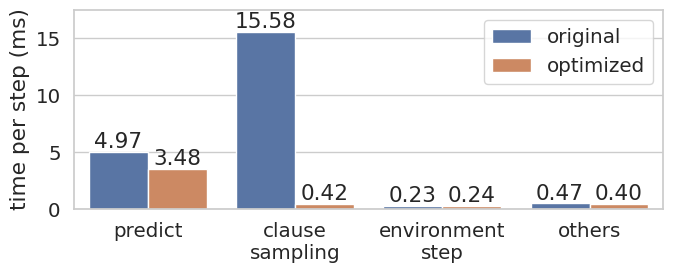

In [14]:
def get_perf(h: History):
    # Use only the training data, and skip the first step
    episode = h.episode.xs(np.nan, level="eval_episode").loc[1:2]
    step = h.step.xs(np.nan, level="eval_episode").loc[1:2]
    return get_group(episode, "timing").sum() / len(step)


perf = pd.DataFrame(
    [
        get_perf(s1["uniform"]),
        get_perf(s1["base"]),
    ]
)
perf["sampling_method"] = ["original", "optimized"]
perf["step"] -= perf["sample_pairs"]
perf = perf.rename(
    columns={
        "callbacks": "others",
        "predict": "predict",
        "sample_pairs": "clause\nsampling",
        "step": "environment\nstep",
    }
)
perf["others"] = perf.pop("others")

perf_molten = perf.melt(
    id_vars=["sampling_method"],
    var_name="component",
    value_name="timing",
)
perf_molten["timing"] *= 1e3

plt.figure(figsize=(7, 3))
ax = sns.barplot(x="component", y="timing", hue="", data=perf_molten.rename(columns={"sampling_method": ""}))
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f")
plt.xlabel("")
plt.ylabel("time per step (ms)")
plt.ylim(0, 17.5)
plt.legend()
plt.tight_layout()
savefig("figs/1_sampling_performance.png")

perf = perf.set_index("sampling_method") * 1e3
perf["overall"] = perf.sum(axis=1)
perf.loc["speedup"] = perf.loc["original"] / perf.loc["optimized"]
perf


In [10]:
perf["clause\nsampling"] / perf["overall"]


sampling_method
uniform    0.732792
g2sat      0.092999
speedup    7.879531
dtype: float64

## 2. Analysis of Metrics

In [26]:
s2 = {
    experiment.name[4:-1]: load_history(experiment.name)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s2 (*)"))
}


Loaded history from s2 (metric=conflicts)
Loaded history from s2 (metric=conflicts, overlaps)
Loaded history from s2 (metric=decisions)
Loaded history from s2 (metric=decisions, overlaps)
Loaded history from s2 (metric=decisions, overlaps, int_rewards)
Loaded history from s2 (metric=decisions, overlaps, run=2)
Loaded history from s2 (metric=decisions, overlaps, run=3)
Loaded history from s2 (metric=decisions, overlaps, run=4)
Loaded history from s2 (metric=decisions, run=2)
Loaded history from s2 (metric=decisions, run=3)
Loaded history from s2 (metric=decisions, run=4)
Loaded history from s2 (metric=propagations)
Loaded history from s2 (metric=propagations, overlaps)
Loaded history from s2 (metric=restarts)
Loaded history from s2 (metric=restarts, overlaps)
Loaded history from s2 (metric=time_cpu)
Loaded history from s2 (metric=time_cpu, overlaps)


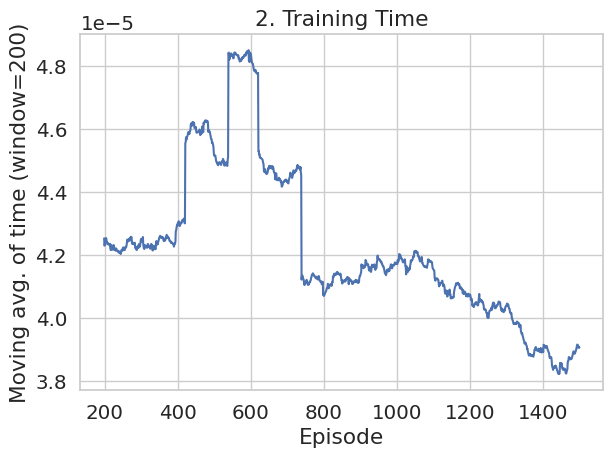

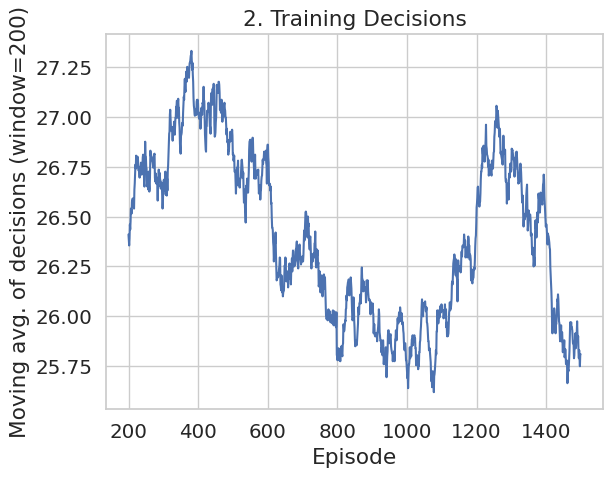

In [7]:
plot_metrics(
    {"": s1["base"]},
    metric="time_cpu",
    legend_title="",
    window_size=200,
    use_median=False,
    saveto=f"figs/2_training_time",
    title=f"2. Training Time",
)

plot_metrics(
    {"": s1["base"]},
    metric="decisions",
    legend_title="Hardness",
    window_size=200,
    saveto=f"figs/2_training_decisions",
    title=f"2. Training Decisions",
)


### 2.2 Metric Correlation
Dedicated notebook: [metrics.ipynb](./metrics.ipynb)

In [42]:
from matplotlib.axes import Axes

metric_cols = ["time_cpu", "restarts", "conflicts", "decisions", "propagations"]


def compute_stats(
    data: pd.DataFrame,
    col: str,
    groupby: str = "instance",
):
    grouped = data.groupby(groupby)[col]
    std = grouped.std(ddof=1) / grouped.mean()

    return {
        "mean": std.mean(),
        "95p": np.percentile(std, 95),
        "99p": np.percentile(std, 99),
        "max": std.max(),
    }


def show_corr(data: pd.DataFrame):
    metrics = data[metric_cols]

    corr = metrics.corr("kendall")
    corr_mask = np.triu(np.ones(len(corr)))
    sns.heatmap(
        corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", mask=corr_mask
    )
    plt.grid()


def rename_ticks(mapping: dict | None = None, ax: Axes=None):
    if ax is None:
        for ax in plt.gcf().axes:
            rename_ticks(mapping, ax)
        return

    if mapping is None:
        mapping = {
            "time_cpu": "time",
        }

    ax = plt.gca()
    x = ax.get_xticklabels()
    ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])
    y = ax.get_yticklabels()
    ax.set_yticklabels([mapping.get(v.get_text(), v.get_text()) for v in y])


def hash_df(df: pd.DataFrame):
    h = hashlib.sha1()
    for col in df.columns:
        h.update(col.encode())
        h.update(b"\0")
    h.update(pd.util.hash_pandas_object(df).values)
    return h.hexdigest()


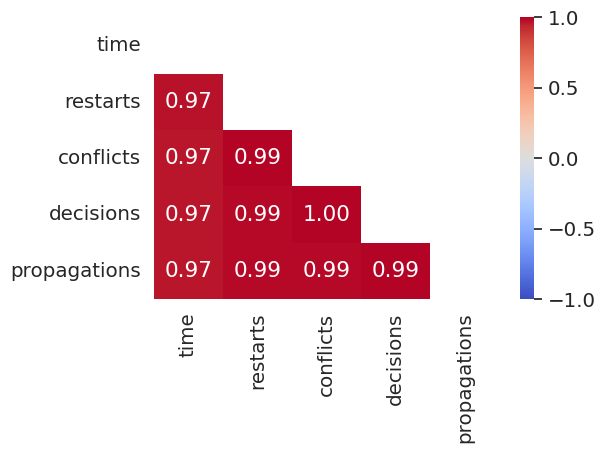

mean       95p       99p       max
small  0.561596  1.243060  2.368558  5.112304
lage   0.088327  0.216136  0.328717  0.851689

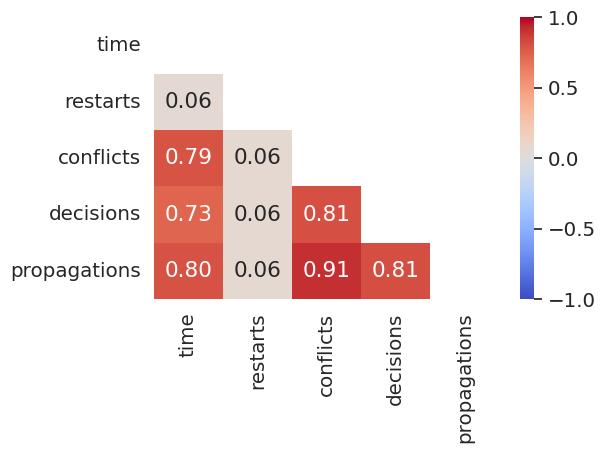

In [43]:
large = pd.read_csv("../instances/random_large/metrics.csv")
small = pd.read_csv("../instances/random_small/metrics.csv")

show_corr(large)
plt.grid(False)
rename_ticks()
plt.tight_layout()
savefig("figs/2_corr_large.png")
plt.show()

show_corr(small)
plt.grid(False)
ax = plt.gca()
rename_ticks()
plt.tight_layout()
savefig("figs/2_corr_small.png")

pd.DataFrame(
    {
        "small": compute_stats(small, "time_cpu"),
        "lage": compute_stats(large, "time_cpu"),
    }
).T


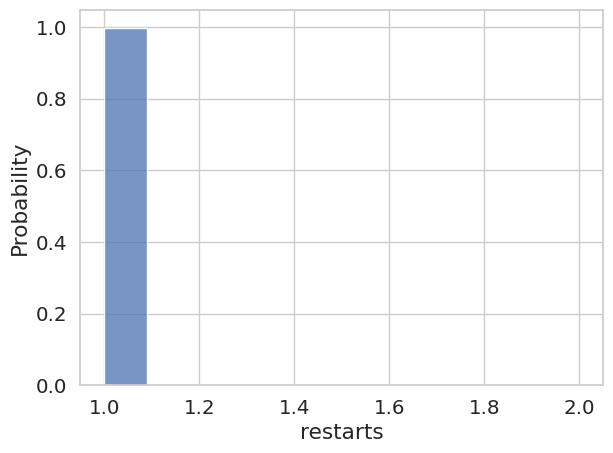

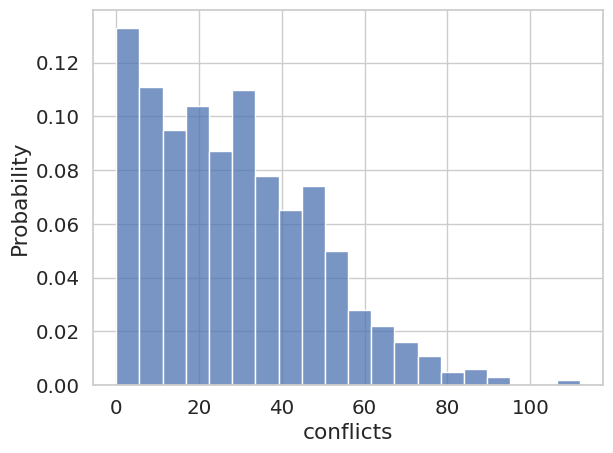

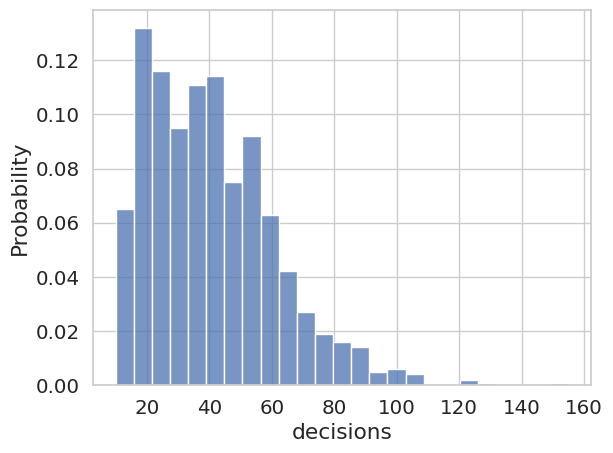

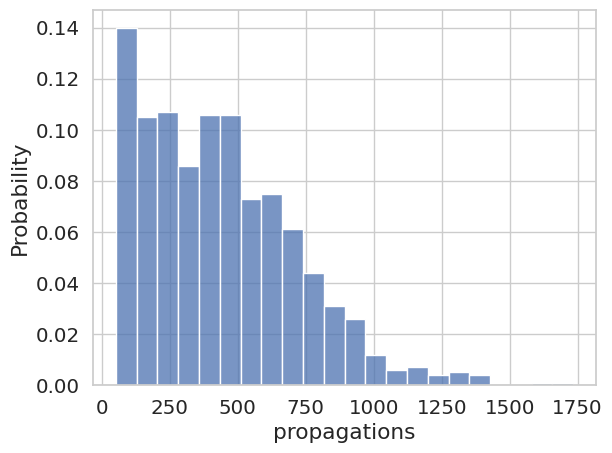

In [20]:
# The only metric which should vary when running with a fixed instance is time_cpu
assert (small.groupby("instance")[metric_cols].std().drop("time_cpu", axis=1) == 0).all().all()
small_dedup = small.groupby("instance")[metric_cols].first()

for col in metric_cols:
    if col == "time_cpu":
        continue
    sns.histplot(x=col, data=small_dedup, stat="probability")
    plt.tight_layout()
    savefig(f"figs/2_hist_{col}.png")
    plt.show()


In [11]:
small_dedup.describe()


time_cpu     restarts    conflicts    decisions  propagations
count  1000.000000  1000.000000  1000.000000  1000.000000   1000.000000
mean      0.000097     1.002000    28.318000    40.592000    435.409000
std       0.000055     0.044699    19.957735    20.371513    280.480672
min       0.000019     1.000000     0.000000    10.000000     51.000000
25%       0.000055     1.000000    12.000000    24.000000    208.750000
50%       0.000086     1.000000    26.000000    37.000000    399.000000
75%       0.000127     1.000000    41.000000    53.000000    608.000000
max       0.000334     2.000000   112.000000   155.000000   1734.000000

/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])
/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])
/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])
/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])


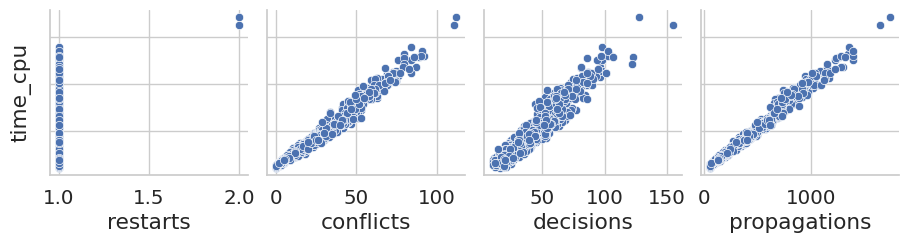

/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])
/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])
/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])
/tmp/ipykernel_73891/3112046948.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(v.get_text(), v.get_text()) for v in x])


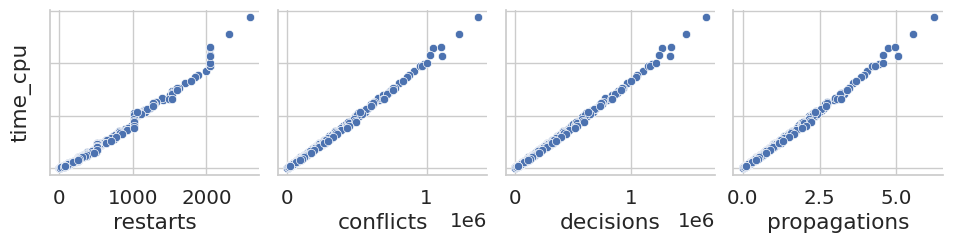

In [12]:
ax = sns.pairplot(
    data=small.groupby("instance").mean(),
    x_vars=["restarts", "conflicts", "decisions", "propagations"],
    y_vars="time_cpu",
)
rename_ticks()
savefig(f"figs/2_pairplot_small.png")
plt.show()

sns.pairplot(
    data=large.groupby("instance").mean(),
    x_vars=["restarts", "conflicts", "decisions", "propagations"],
    y_vars="time_cpu",
)
rename_ticks()
savefig(f"figs/2_pairplot_large.png")
plt.show()



## 3. Training Variance and Reproducibility

In [27]:
s5 = {
    experiment.name[4:-1]: load_history(experiment.name)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s5 (*)"))
}


Loaded history from s5 (template_mode=fixed_random, run 1)
Loaded history from s5 (template_mode=fixed_random, run 2)
Loaded history from s5 (template_mode=fixed_random, run 3)
Loaded history from s5 (template_mode=random)


Loaded history from s1 (base run)


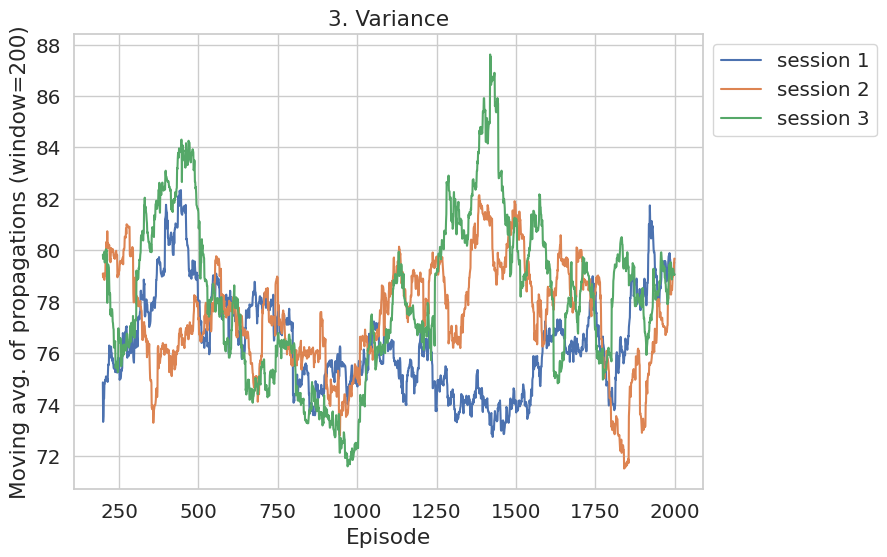

In [35]:
s1_base = load_history(s1["base"].directory.name)
runs = {
    "session 1": s1_base,
    "session 2": s2["metric=time_cpu"],
    "session 3": s5["template_mode=random"],
}

for k in list(runs):
    h = History(runs[k].directory, runs[k].step, runs[k].reruns, runs[k].episode, runs[k].evaluation)
    h.episode = h.episode[h.episode.index.get_level_values("episode") <= 2000]
    runs[k] = h

plt.figure(figsize=(7.4, 5.6))
plot_metrics(
    runs,
    metric="propagations",
    legend_title="",
    window_size=200,
    saveto=f"figs/3_variance",
    title=f"3. Variance",
    new_figure=False,
    move_legend=True,
)
# plt.xlim(0, 2000)


## 4. Hyperparameter Tuning

In [4]:
s8 = {
    experiment.name[4:-1]: load_history(experiment.name)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s8 (*)"))
    if "BROKEN" not in experiment.name and "repeat" not in experiment.name
}

s8_repeat, s8 = filter_exps(s8, ", repeat")
s8_ir, s8_base = filter_exps(s8, ", int_rewards")

s12 = {
    experiment.name[5:-1]: load_history(experiment.name)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob("s12 (*)"))
}


Loaded history from s8 (lr=1e-3)
Loaded history from s8 (lr=1e-3, int_rewards)
Loaded history from s8 (lr=1e-3, overlaps)
Loaded history from s8 (lr=1e-3, overlaps, int_rewards)
Loaded history from s8 (lr=1e-4)
Loaded history from s8 (lr=1e-4, int_rewards)
Loaded history from s8 (lr=1e-4, overlaps)
Loaded history from s8 (lr=1e-4, overlaps, int_rewards)
Loaded history from s8 (lr=1e-5)
Loaded history from s8 (lr=1e-5, int_rewards)
Loaded history from s8 (lr=1e-5, overlaps)
Loaded history from s8 (lr=1e-5, overlaps, int_rewards)
Loaded history from s12 (action_mode=sample)
Loaded history from s12 (baseline)
Loaded history from s12 (baseline, lr=5e-5(0.9995))
Loaded history from s12 (metric=time_cpu, int_rewards)
Loaded history from s12 (metric=time_cpu, int_rewards, lr=5e-5(0.9995))
Loaded history from s12 (network_dim=64)
Loaded history from s12 (network_layers=5)
Loaded history from s12 (network_layers=5, network_dim=64)
Loaded history from s12 (network_layers=5, network_dim=64, lr=5e

(64.0, 83.0)

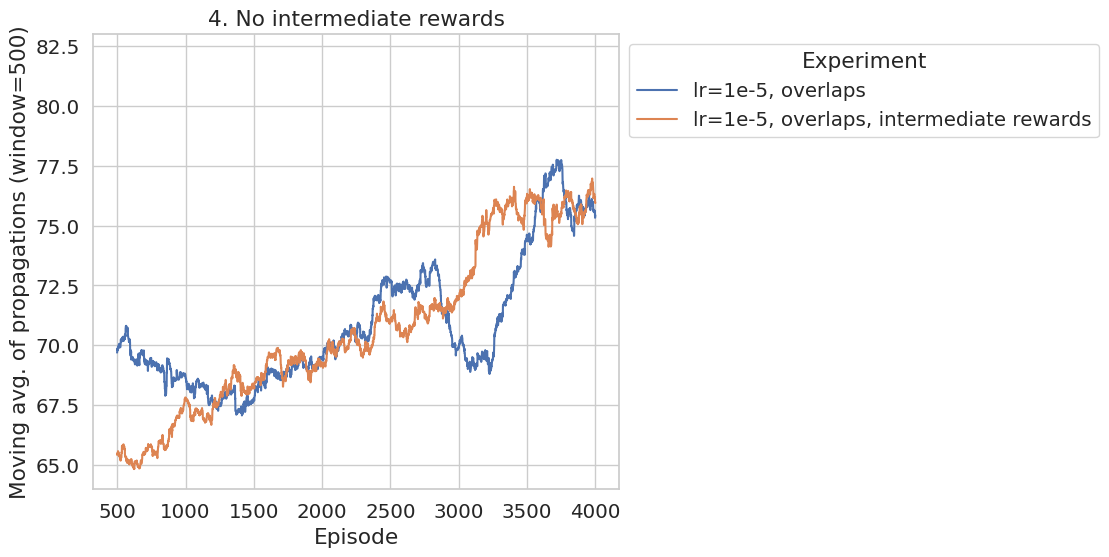

In [8]:
plt.figure(figsize=(6.4, 5.6))
plot_metrics(
    {
        "lr=1e-5, overlaps": s8_base["lr=1e-5, overlaps"],
        "lr=1e-5, overlaps, intermediate rewards": s8_ir["lr=1e-5, overlaps"],
    },
    move_legend=True,
    window_size=500,
    new_figure=False,
    metric="propagations",
    saveto="figs/4_best",
    title="4. No intermediate rewards",
)
plt.ylim(64, 83)


(64.0, 83.0)

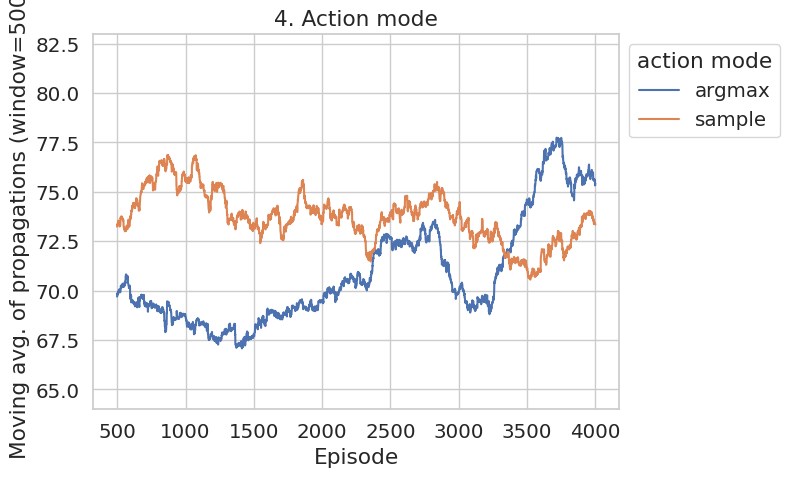

In [17]:
h_sample = s12["action_mode=sample"]
h_sample = History(
    h_sample.directory,
    h_sample.step,
    h_sample.reruns,
    h_sample.episode,
    h_sample.evaluation,
)
h_sample.episode = h_sample.episode[
    h_sample.episode.index.get_level_values("episode") < 4000
]
plot_metrics(
    {
        "argmax": s8_base["lr=1e-5, overlaps"],
        "sample": h_sample,
    },
    legend_title="action mode",
    move_legend=True,
    window_size=500,
    metric="propagations",
    saveto="figs/4_action_mode",
    title="4. Action mode",
)
plt.ylim(64, 83)


## 5. Stabilizing Execution Time

In [37]:
s9 = {
    experiment.name[4:-1]: load_history(experiment.name, load_reruns="time_cpu" in experiment.name and "int_rewards" not in experiment.name)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s9 (*)"))
}

s9_sole_proc, s9 = filter_exps(s9, "rerun_sole_proc, ")
s9_time, _ = filter_exps(s9, "metric=time_cpu, ")
_, s9_time_base = filter_exps(s9_time, ", int_rewards")


Loaded history from s9 (metric=propagations)
Loaded history from s9 (metric=propagations, overlaps)
Loaded history from s9 (metric=propagations, overlaps, int_rewards)
Loaded history from s9 (metric=time_cpu, reps=2, agg=min, overlaps)
Loaded history from s9 (metric=time_cpu, reps=2, agg=min, overlaps, int_rewards)
Loaded history from s9 (metric=time_cpu, reps=3, agg=median, overlaps)
Loaded history from s9 (metric=time_cpu, reps=3, agg=median, overlaps, int_rewards)
Loaded history from s9 (rerun_sole_proc, metric=propagations, reps=10, agg=median, overlaps)
Loaded history from s9 (rerun_sole_proc, metric=time_cpu, reps=10, agg=median, overlaps)


In [38]:
def get_random_means(
    df: pd.DataFrame,
    group_size: int = 3,
    agg_fn: str = "mean",
    random_state: int = 42,
):
    resampled = df.sample(
        len(df) * group_size, replace=True, random_state=random_state
    ).reset_index(drop=True)
    means = resampled.rolling(group_size).agg(agg_fn)
    non_overlapping_means = means[group_size - 1 :: group_size]
    non_overlapping_means.reset_index(drop=True, inplace=True)
    non_overlapping_means.index.name = "run"
    return non_overlapping_means


def resample_and_average_times(
    df: pd.DataFrame,
    group_size: int = 3,
    agg_fn: str = "median",
    random_state: int = 42,
) -> pd.DataFrame:
    if group_size == 1:
        return df.copy()

    h = hash_df(df)
    cache_file = (
        Path(".cache") / f"{agg_fn}({group_size})_seed{random_state}_{h}.parquet"
    )
    if cache_file.exists():
        return pd.read_parquet(cache_file)

    result = (
        df.groupby("instance", sort=False)
        .apply(
            lambda x: get_random_means(
                x[metric_cols],
                group_size=group_size,
                agg_fn=agg_fn,
                random_state=random_state,
            )
        )
        .reset_index()
        .convert_dtypes()
    )

    cache_file.parent.mkdir(parents=True, exist_ok=True)
    result.to_parquet(cache_file, compression="gzip")
    return result


In [44]:
group_sizes = (1, 2, 3, 5, 10, 15, 20, 50)
agg_fns = ("mean", "median", "min")
small_agg = []

for size, agg_fn in tqdm(list(itertools.product(group_sizes, agg_fns))):
    result = resample_and_average_times(small, group_size=size, agg_fn=agg_fn)
    result["group_size"] = size
    result["agg_fn"] = agg_fn
    small_agg.append(result)

small_agg = pd.concat(small_agg)


  0%|          | 0/24 [00:00<?, ?it/s]

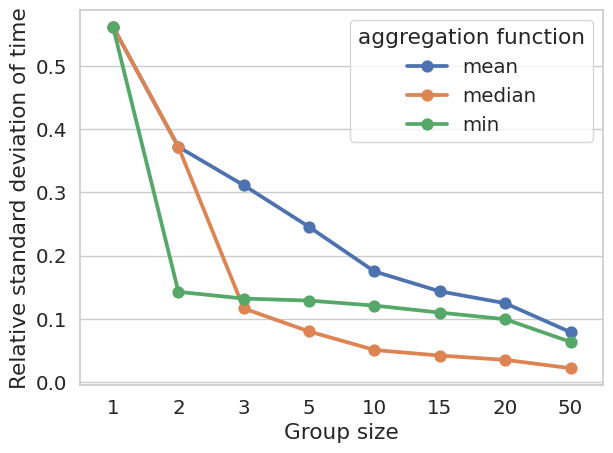

In [ ]:
time_grouped = small_agg.groupby(["instance", "group_size", "agg_fn"])["time_cpu"]
std = time_grouped.std() / time_grouped.mean()
std.name = "time_cpu_std"
stats = std.reset_index()
stats = stats.rename(columns={"agg_fn": "aggregation function"})

sns.pointplot(
    x="group_size",
    y="time_cpu_std",
    hue="aggregation function",
    estimator="mean",
    # errorbar=("pi", 95),
    errorbar=None,
    # dodge=0.2,
    dodge=0,
    data=stats,
)
plt.ylabel("Relative standard deviation of time")
plt.xlabel("Group size")
plt.tight_layout()
savefig("figs/5_agg_comparison")


In [ ]:
1 - stats.groupby(["group_size", "aggregation function"]).mean() / 0.561596


instance  time_cpu_std
group_size aggregation function                          
1          mean                 -888.429412          -0.0
           median               -888.429412          -0.0
           min                  -888.429412          -0.0
2          mean                 -888.429412      0.337607
           median               -888.429412      0.337607
           min                  -888.429412      0.745451
3          mean                 -888.429412      0.445631
           median               -888.429412      0.792137
           min                  -888.429412      0.764325
5          mean                 -888.429412      0.562862
           median               -888.429412      0.856897
           min                  -888.429412      0.770049
10         mean                 -888.429412      0.688115
           median               -888.429412      0.909014
           min                  -888.429412      0.784104
15         mean                 -888.429412      0.744017
           median               -888.429412      0.924711
           min                  -888.429412      0.803768
20         mean                 -888.429412      0.777421
           median               -888.429412      0.936777
           min                  -888.429412      0.822415
50         mean                 -888.429412      0.858903
           median               -888.429412       0.96022
           min                  -888.429412       0.88623

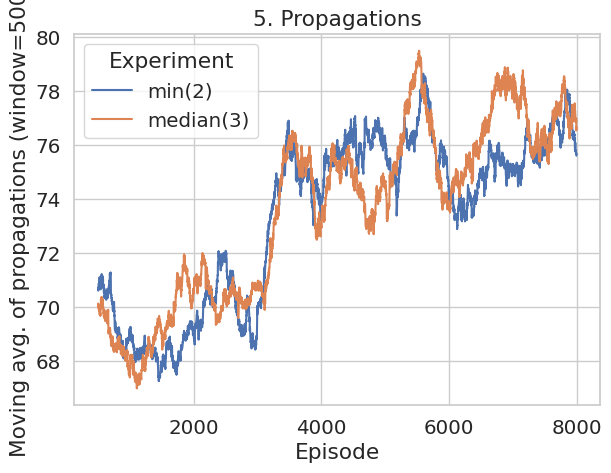

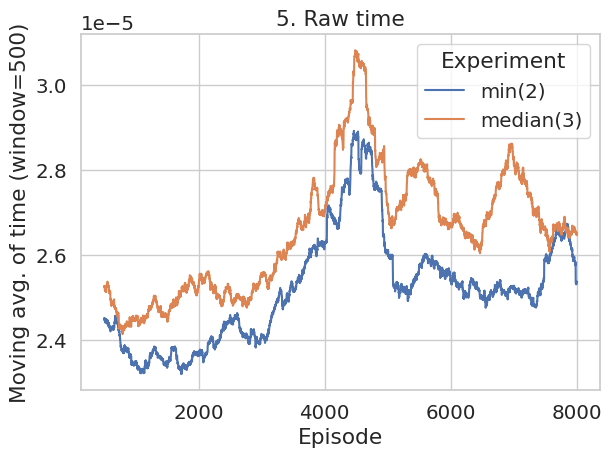

In [ ]:
plot_metrics(
    {
        "min(2)": s9_time_base["reps=2, agg=min, overlaps"],
        "median(3)": s9_time_base["reps=3, agg=median, overlaps"],
    },
    # move_legend=True,
    window_size=500,
    metric="propagations",
    saveto="figs/5_cmp_propagations",
    title="5. Propagations",
)


plot_metrics(
    {
        "min(2)": s9_time_base["reps=2, agg=min, overlaps"],
        "median(3)": s9_time_base["reps=3, agg=median, overlaps"],
    },
    # move_legend=True,
    window_size=500,
    metric="time_cpu",
    use_median=False,
    saveto="figs/5_cmp_time",
    title="5. Raw time",
)


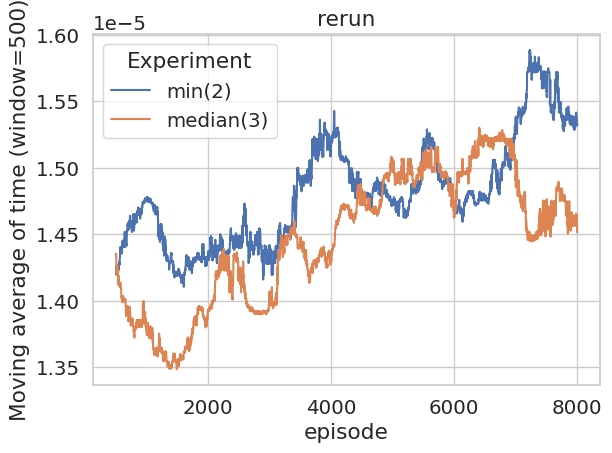

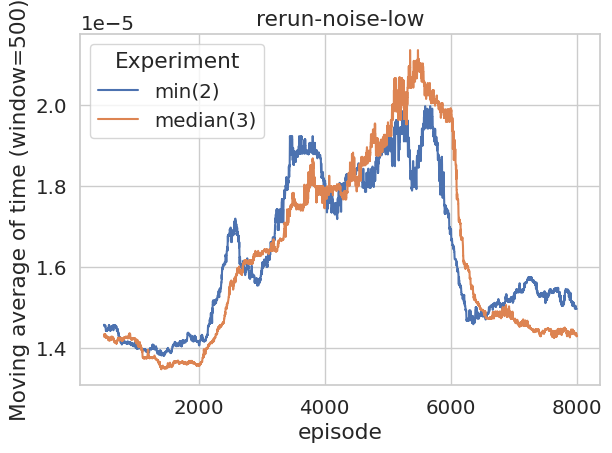

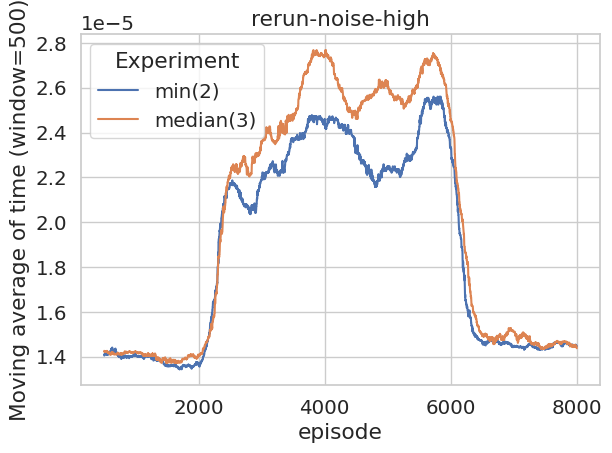

In [24]:
for rerun_type in ("rerun", "rerun-noise-low", "rerun-noise-high"):
    for name, h in s9_time_base.items():
        episode_times = h.reruns[rerun_type].groupby("episode")["time_cpu"].mean()
        episode_times.rolling(500).median().plot(
            label={
                "reps=2, agg=min, overlaps": "min(2)",
                "reps=3, agg=median, overlaps": "median(3)",
            }[name]
        )
    plt.ylabel("Moving average of time (window=500)")
    plt.title(rerun_type)
    plt.legend(title="Experiment")
    plt.tight_layout()
    savefig(f"figs/5_cmp_time_{rerun_type}")
    plt.show()


kendall corr: 0.641502027398571


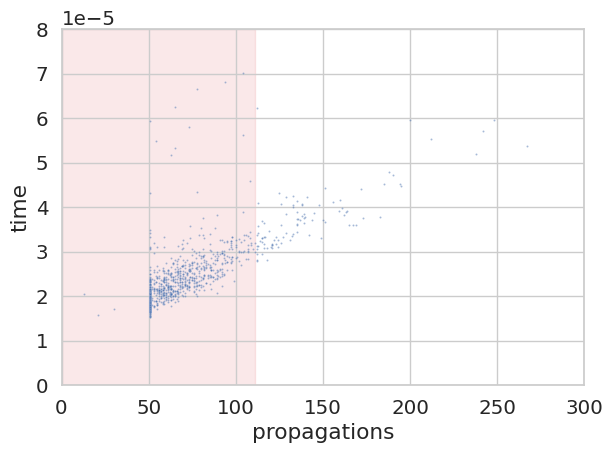

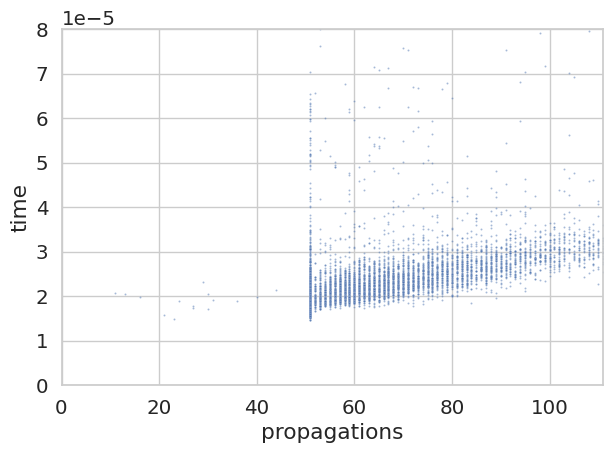

In [8]:
ep = s9["metric=time_cpu, reps=2, agg=min, overlaps"].episode
m = get_group(ep, "metrics").xs(None, level="eval_episode")
print("kendall corr:", m.corr("kendall").loc["time_cpu", "propagations"])

# plt.figure(figsize=(5, 3))
sns.scatterplot(x="propagations", y="time_cpu", data=m.sample(1000), s=2, alpha=0.5)
plt.axvspan(0, m["propagations"].quantile(0.9), color='tab:red', alpha=0.1, zorder=-1000)
plt.xlim(0, 300)
plt.ylim(0, 0.00008)
plt.ylabel("time")
plt.tight_layout()
savefig("figs/5_scatter")
plt.show()

# plt.figure(figsize=(5, 3))
sns.scatterplot(x="propagations", y="time_cpu", data=m, s=2, alpha=0.5)
plt.xlim(0, m["propagations"].quantile(0.9))
plt.ylim(0, 0.00008)
plt.ylabel("time")
plt.tight_layout()
savefig("figs/5_scatter_zoom")
plt.show()


## 6. Learning on a Single Template

In [9]:
s10 = {
    experiment.name[5:-1]: load_history(experiment.name)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s10 (*)"))
    if "propagations" in experiment.name
}

s10_props, _ = filter_exps(s10, "metric=propagations, ")


Loaded history from s10 (metric=propagations, overlaps)
Loaded history from s10 (metric=propagations, overlaps, int_rewards)
Loaded history from s10 (metric=propagations, single_template, overlaps)
Loaded history from s10 (metric=propagations, single_template, overlaps, int_rewards)


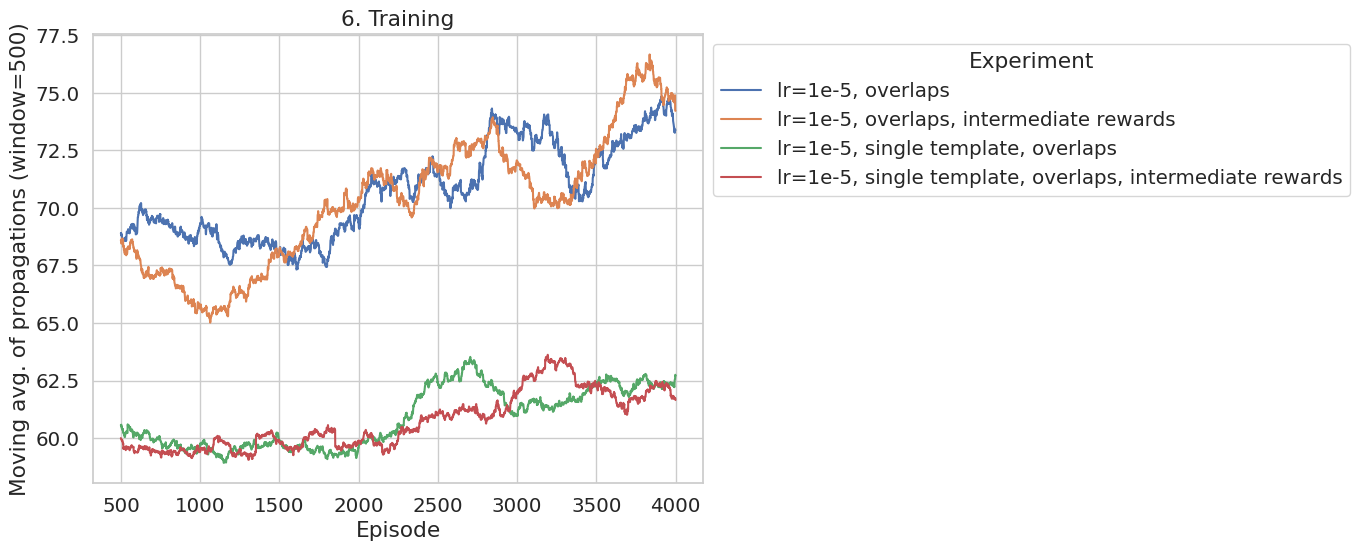

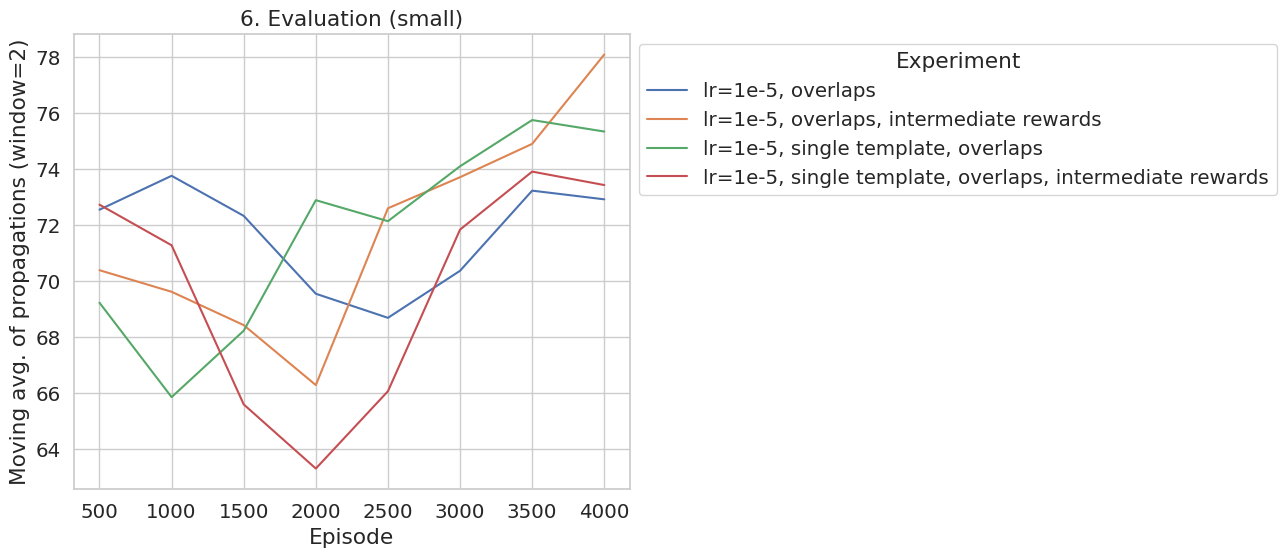

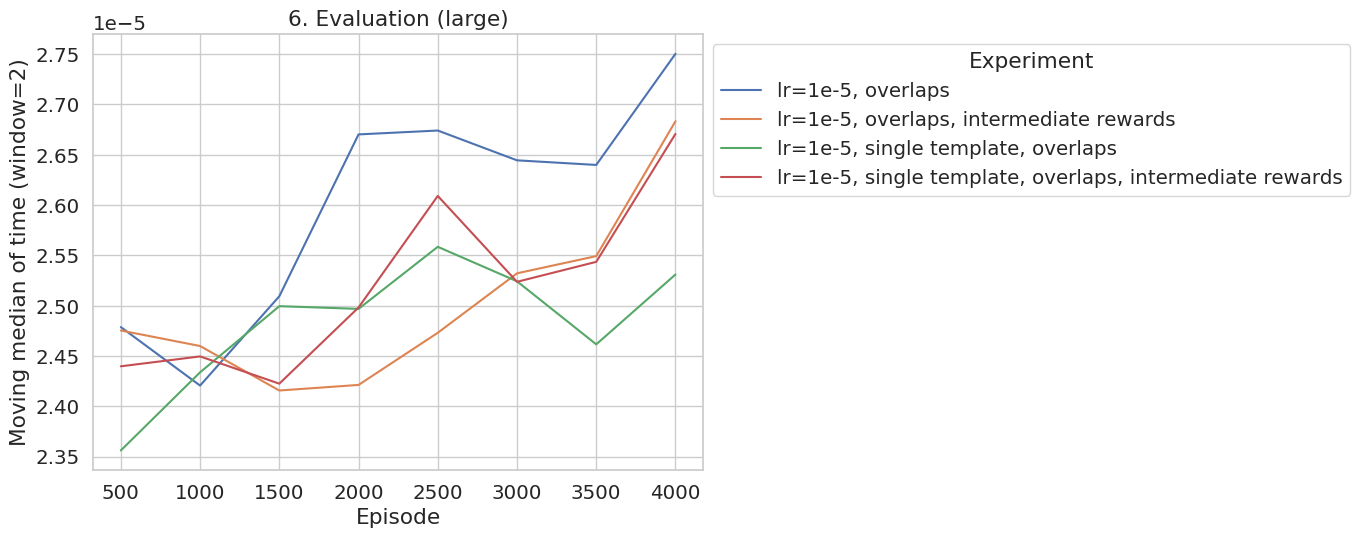

In [17]:
s10_props_x = {
    "lr=1e-5, overlaps": s10_props["overlaps"],
    "lr=1e-5, overlaps, intermediate rewards": s10_props["overlaps, int_rewards"],
    "lr=1e-5, single template, overlaps": s10_props["single_template, overlaps"],
    "lr=1e-5, single template, overlaps, intermediate rewards": s10_props["single_template, overlaps, int_rewards"],
}

plt.figure(figsize=(7.4, 5.6))
plot_metrics(
    s10_props_x,
    move_legend=True,
    window_size=500,
    metric="propagations",
    new_figure=False,
    saveto="figs/6_training",
    title="6. Training",
)

plt.figure(figsize=(7.4, 5.6))
plot_metrics(
    s10_props_x,
    move_legend=True,
    evaluation=True,
    template_size=630,
    window_size=2,
    new_figure=False,
    metric="propagations",
    saveto="figs/6_eval_small",
    title="6. Evaluation (small)",
)

plt.figure(figsize=(7.4, 5.6))
plot_metrics(
    s10_props_x,
    move_legend=True,
    new_figure=False,
    evaluation=True,
    template_size=630*2,
    window_size=2,
    saveto="figs/6_eval_large",
    title="6. Evaluation (large)",
)


## 7. Restricting Clause Sampling

In [28]:
s12 = {
    experiment.name[5:-1]: load_history(experiment.name)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s12 (*)"))
}

s12_sampled_pairs, _ = filter_exps(s12, r"num_sampled_pairs=\d+$|baseline$", update_keys=False)
s12_large_nets, _ = filter_exps(s12, r"network_layers.*=\d+$|baseline$", update_keys=False)


Loaded history from s12 (action_mode=sample)
Loaded history from s12 (baseline)
Loaded history from s12 (baseline, lr=5e-5(0.9995))
Loaded history from s12 (metric=time_cpu, int_rewards)
Loaded history from s12 (metric=time_cpu, int_rewards, lr=5e-5(0.9995))
Loaded history from s12 (network_dim=64)
Loaded history from s12 (network_layers=5)
Loaded history from s12 (network_layers=5, network_dim=64)
Loaded history from s12 (network_layers=5, network_dim=64, lr=5e-5(0.9995))
Loaded history from s12 (network_layers=5, network_dim=64, num_sampled_pairs=400, lr=5e-5(0.9995))
Loaded history from s12 (num_sampled_pairs=200)
Loaded history from s12 (num_sampled_pairs=400)
Loaded history from s12 (num_sampled_pairs=400, lr=5e-5(0.9995))


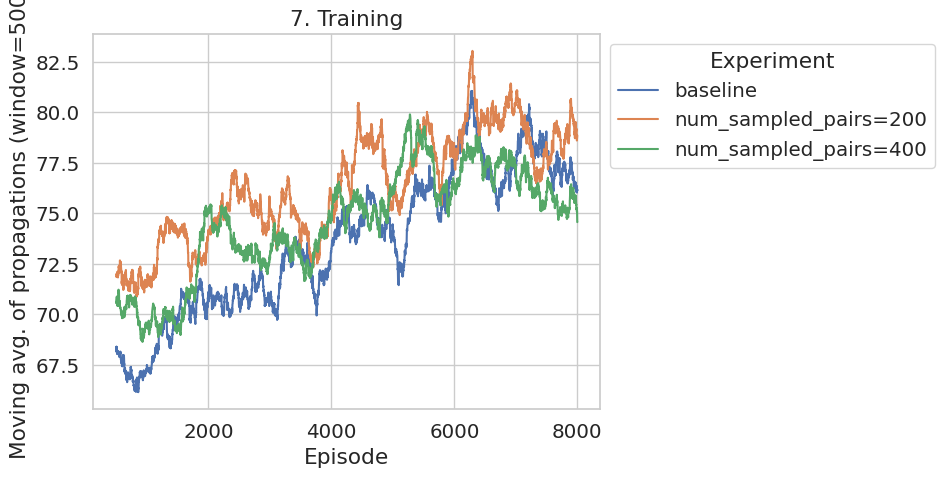

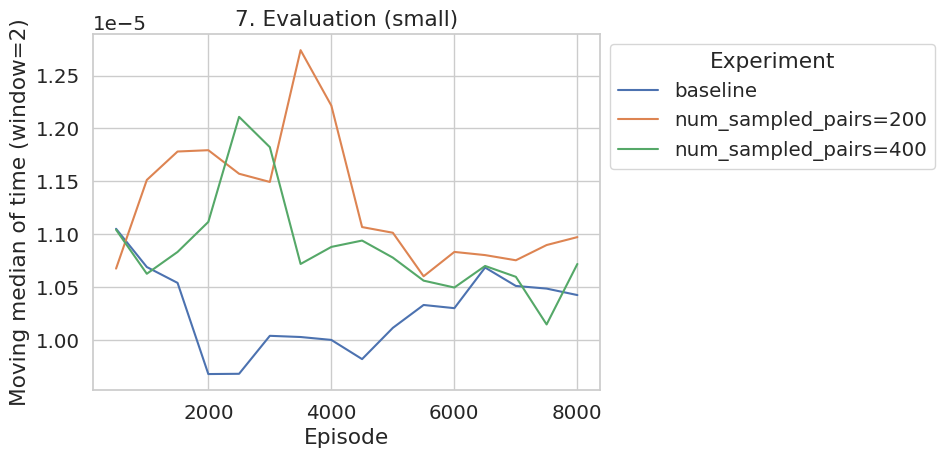

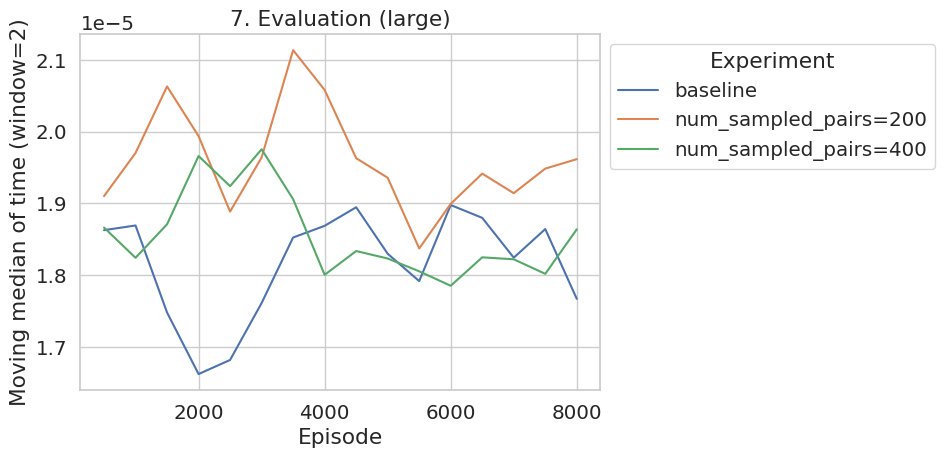

In [29]:
plot_metrics(
    s12_sampled_pairs,
    move_legend=True,
    window_size=500,
    metric="propagations",
    saveto="figs/7_train",
    title="7. Training",
)

plot_metrics(
    s12_sampled_pairs,
    move_legend=True,
    evaluation=True,
    template_size=630,
    window_size=2,
    saveto="figs/7_eval_small",
    title="7. Evaluation (small)",
)

plot_metrics(
    s12_sampled_pairs,
    move_legend=True,
    evaluation=True,
    template_size=630*2,
    window_size=2,
    saveto="figs/7_eval_large",
    title="7. Evaluation (large)",
)


## 8. Larger Networks

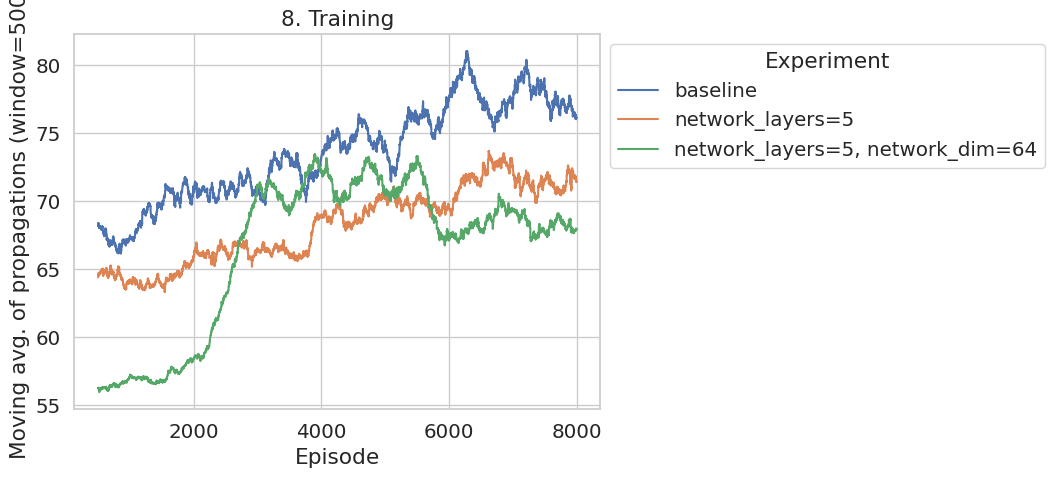

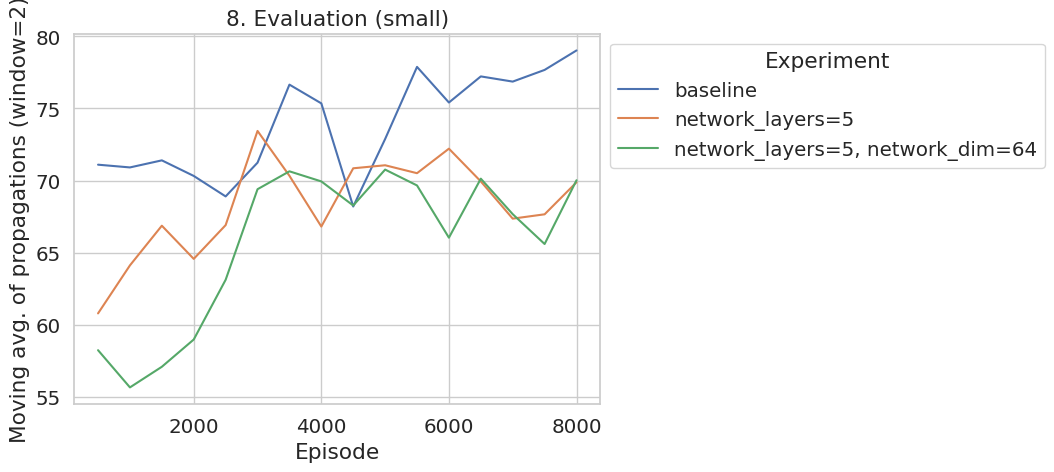

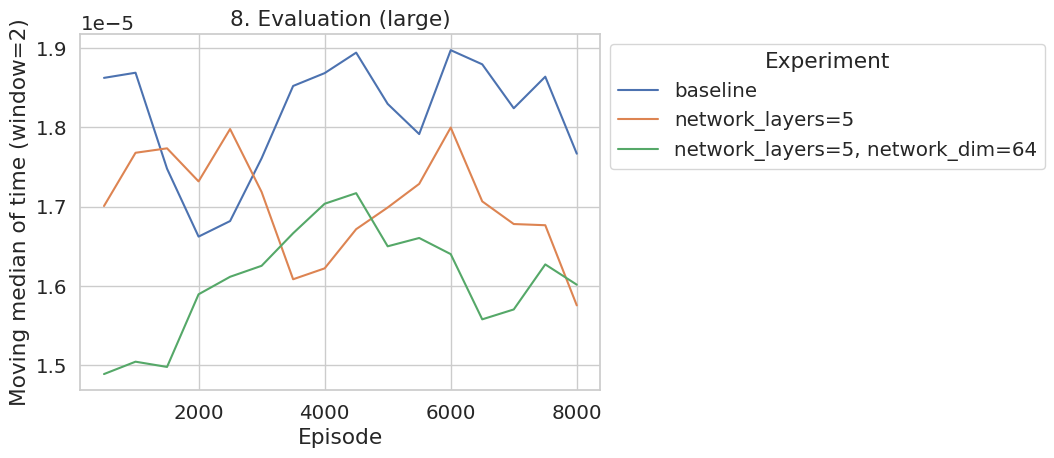

In [30]:
plot_metrics(
    s12_large_nets,
    move_legend=True,
    window_size=500,
    metric="propagations",
    saveto="figs/8_train",
    title="8. Training",
)

plot_metrics(
    s12_large_nets,
    move_legend=True,
    evaluation=True,
    template_size=630,
    window_size=2,
    metric="propagations",
    saveto="figs/8_eval_small",
    title="8. Evaluation (small)",
)

plot_metrics(
    s12_large_nets,
    move_legend=True,
    evaluation=True,
    template_size=630*2,
    window_size=2,
    saveto="figs/8_eval_large",
    title="8. Evaluation (large)",
)


## 9. Model Evaluation

In [22]:
s14 = {
    experiment.name[5:-1]: load_history(experiment.name, load_eval=True)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s14 (*)"))
}
s16 = {
    experiment.name[5:-1]: load_history(experiment.name, load_eval=True)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s16 (*)"))
}
s17 = {
    experiment.name[5:-1]: load_history(experiment.name, load_eval=True)
    for experiment in sorted(Path("../lamgate/runs/SAGE").glob(f"s18 (*)"))  # intentionally s18
}


Loaded history from s14 (defaults, lr=1e-5(0.9999))
Loaded history from s14 (defaults, lr=1e-5)
Loaded history from s14 (defaults, lr=2e-5(0.9999))
Loaded history from s14 (num_sampled_pairs=200, lr=1e-5)
Loaded history from s14 (num_sampled_pairs=200, lr=2e-5(0.9999))
Loaded history from s14 (single_template, int_rewards, lr=1e-5)
Loaded history from s14 (single_template, int_rewards, lr=2e-5(0.9999))
Loaded history from s14 (single_template, int_rewards, num_sampled_pairs=200, lr=1e-5)
Loaded history from s14 (single_template, int_rewards, num_sampled_pairs=200, lr=2e-5(0.9999))
Loaded history from s16 (num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5)
Loaded history from s18 (num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-0.25)
Loaded history from s18 (num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-1)
Loaded history from s18 (num_sampled_pairs=200, lr=2e-5(0.9999), complexify=0-0.25)
Loaded history from s18 (num_sampled_pairs=200, lr=2e-5(0.9999), 

In [23]:
s14_16_17 = []
for session_num, session in {14: s14, 16: s16, 17: s17}.items():
    for name, h in session.items():
        s14_16_17.append((session_num, name, h))

results = []
for session_num, name, h in tqdm(s14_16_17):
    r = {
        'name': name,
        'raw_path': h.directory.resolve().name,
        'session': session_num
    }
    episode_eval = h.episode.loc[h.episode.index.dropna()]
    sizes = episode_eval["template"].map(_template_size)

    episode_eval_small = episode_eval[sizes == 630]
    eval_scores_small = get_group(episode_eval_small, "metrics").groupby("episode").mean(numeric_only=True)
    props_small = eval_scores_small["propagations"]
    r['propagations'] =  props_small.max()
    r['propagations_at_ep'] =  props_small.idxmax()

    episode_eval_large = episode_eval[sizes == 630*2]
    eval_scores_large = get_group(episode_eval_large, "metrics").groupby("episode").mean(numeric_only=True)
    props_large = eval_scores_large["propagations"]
    r['propagations_large'] = props_large.max()
    r['propagations_large_at_ep'] = props_large.idxmax()

    complexify_path = h.directory / "complexify.parquet"
    if complexify_path.exists():
        complexify = pd.read_parquet(complexify_path)
        molten = complexify.melt(id_vars=["num_vars", "alpha", "percent_split", "solver", "num_sampled_pairs", "run", "episode"], value_vars=["propagations", "propagations/original"])

        x = complexify.groupby(["solver", "num_vars", "alpha", "percent_split"]).mean(numeric_only=True)
        x = x.loc["PySAT(minisat22)", 200, 4.2]
        improvements = x["propagations"] / x["propagations/original"].values
        r['complex420'] = improvements.max()
        r['complex420_splits'] = improvements.idxmax()
        
        if (complexify["alpha"] == 6.75).any():
            x = complexify.groupby(["solver", "num_vars", "alpha", "percent_split"]).mean(numeric_only=True)
            x = x.loc["PySAT(minisat22)", 200, 6.75]
            improvements = x["propagations"] / x["propagations/original"].values
            r['complex625'] = improvements.max()
            r['complex625_splits'] = improvements.idxmax()

    results.append(r)
results = pd.DataFrame(results).set_index(["session", "name"], drop=True)


  0%|          | 0/14 [00:00<?, ?it/s]

In [24]:
with pd.option_context('display.multi_sparse', False):
    display(results.loc[:16].sort_values("propagations_large")[["propagations", "propagations_at_ep", "propagations_large", "propagations_large_at_ep"]])

print(results.loc[:16].sort_values("propagations_large")[["propagations", "propagations_at_ep", "propagations_large", "propagations_large_at_ep"]].to_latex())


propagations  \
session name                                                               
14      defaults, lr=1e-5                                          85.25   
14      defaults, lr=2e-5(0.9999)                                  82.28   
14      single_template, int_rewards, lr=1e-5                      83.77   
14      defaults, lr=1e-5(0.9999)                                  83.66   
14      num_sampled_pairs=200, lr=1e-5                             86.59   
14      num_sampled_pairs=200, lr=2e-5(0.9999)                     84.89   
14      single_template, int_rewards, num_sampled_pairs...         86.95   
16      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5          85.02   
14      single_template, int_rewards, lr=2e-5(0.9999)              85.81   
14      single_template, int_rewards, num_sampled_pairs...         83.26   

                                                            propagations_at_ep  \
session name                                                                     
14      defaults, lr=1e-5                                                 8000   
14      defaults, lr=2e-5(0.9999)                                         4750   
14      single_template, int_rewards, lr=1e-5                             6750   
14      defaults, lr=1e-5(0.9999)                                        12750   
14      num_sampled_pairs=200, lr=1e-5                                    3250   
14      num_sampled_pairs=200, lr=2e-5(0.9999)                            8250   
14      single_template, int_rewards, num_sampled_pairs...               12000   
16      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5                 8750   
14      single_template, int_rewards, lr=2e-5(0.9999)                    12750   
14      single_template, int_rewards, num_sampled_pairs...                4500   

                                                            propagations_large  \
session name                                                                     
14      defaults, lr=1e-5                                               193.32   
14      defaults, lr=2e-5(0.9999)                                       198.24   
14      single_template, int_rewards, lr=1e-5                           200.19   
14      defaults, lr=1e-5(0.9999)                                       201.34   
14      num_sampled_pairs=200, lr=1e-5                                  202.97   
14      num_sampled_pairs=200, lr=2e-5(0.9999)                          205.23   
14      single_template, int_rewards, num_sampled_pairs...              206.01   
16      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5               207.11   
14      single_template, int_rewards, lr=2e-5(0.9999)                   210.03   
14      single_template, int_rewards, num_sampled_pairs...              210.37   

                                                            propagations_large_at_ep  
session name                                                                          
14      defaults, lr=1e-5                                                       3750  
14      defaults, lr=2e-5(0.9999)                                              13000  
14      single_template, int_rewards, lr=1e-5                                  13750  
14      defaults, lr=1e-5(0.9999)                                              12000  
14      num_sampled_pairs=200, lr=1e-5                                          9250  
14      num_sampled_pairs=200, lr=2e-5(0.9999)                                 14750  
14      single_template, int_rewards, num_sampled_pairs...                     13250  
16      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5                       6250  
14      single_template, int_rewards, lr=2e-5(0.9999)                          15250  
14      single_template, int_rewards, num_sampled_pairs...                      9000

\begin{tabular}{llrrrr}
\toprule
 &  & propagations & propagations_at_ep & propagations_large & propagations_large_at_ep \\
session & name &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{14} & defaults, lr=1e-5 & 85.250000 & 8000 & 193.320000 & 3750 \\
 & defaults, lr=2e-5(0.9999) & 82.280000 & 4750 & 198.240000 & 13000 \\
 & single_template, int_rewards, lr=1e-5 & 83.770000 & 6750 & 200.190000 & 13750 \\
 & defaults, lr=1e-5(0.9999) & 83.660000 & 12750 & 201.340000 & 12000 \\
 & num_sampled_pairs=200, lr=1e-5 & 86.590000 & 3250 & 202.970000 & 9250 \\
 & num_sampled_pairs=200, lr=2e-5(0.9999) & 84.890000 & 8250 & 205.230000 & 14750 \\
 & single_template, int_rewards, num_sampled_pairs=200, lr=1e-5 & 86.950000 & 12000 & 206.010000 & 13250 \\
\cline{1-6}
16 & num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5 & 85.020000 & 8750 & 207.110000 & 6250 \\
\cline{1-6}
\multirow[t]{2}{*}{14} & single_template, int_rewards, lr=2e-5(0.9999) & 85.810000 & 12750 & 210.030000 & 15250 \\
 & single_template

In [25]:
best = {
    "single_template, int_rewards": s14["single_template, int_rewards, lr=2e-5(0.9999)"],
    "single_template, int_rewards, num_sampled_pairs=200": s14["single_template, int_rewards, num_sampled_pairs=200, lr=2e-5(0.9999)"],
    "num_sampled_pairs=200": s14["num_sampled_pairs=200, lr=2e-5(0.9999)"],
    "num_sampled_pairs=200, alpha=7.5": s16["num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5"],
}

top1 = s14["single_template, int_rewards, num_sampled_pairs=200, lr=2e-5(0.9999)"]



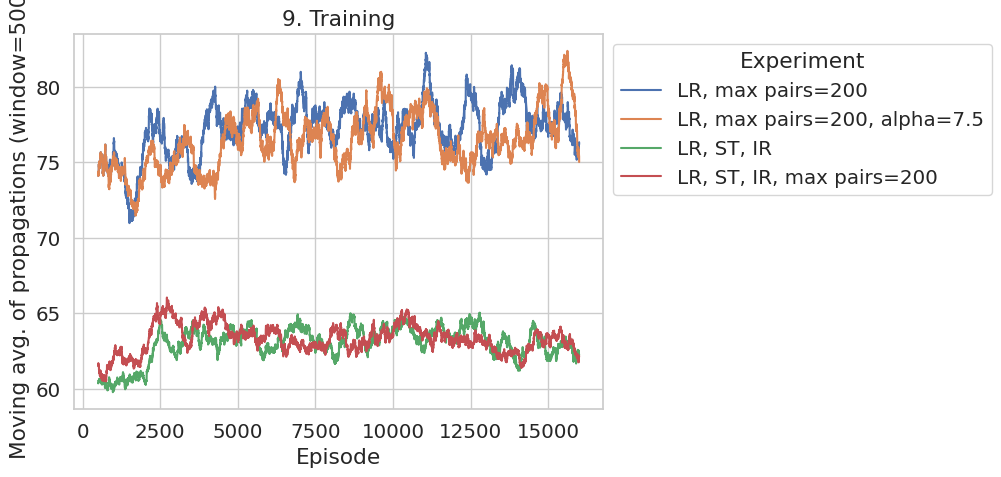

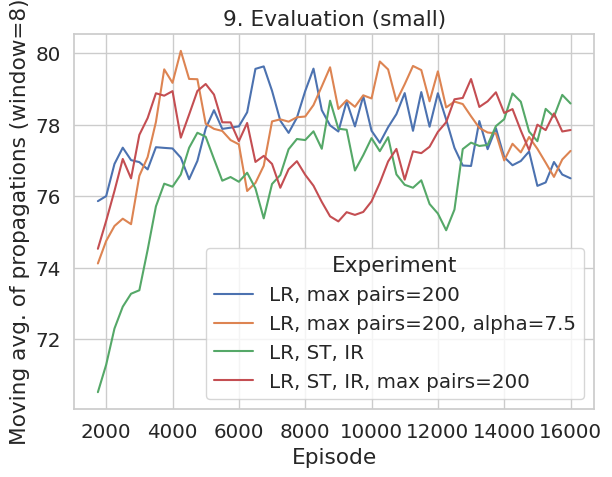

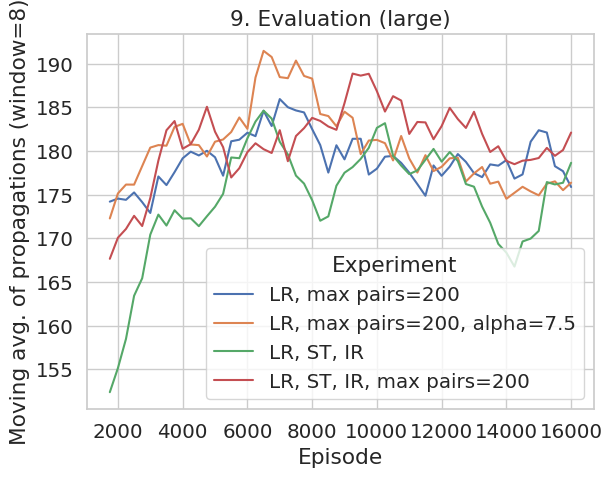

In [26]:
best_x = {
    "LR, max pairs=200": best["num_sampled_pairs=200"],
    "LR, max pairs=200, alpha=7.5": best["num_sampled_pairs=200, alpha=7.5"],
    "LR, ST, IR": best["single_template, int_rewards"],
    "LR, ST, IR, max pairs=200": best["single_template, int_rewards, num_sampled_pairs=200"],
}

plot_metrics(
    best_x,
    move_legend=True,
    window_size=500,
    metric="propagations",
    saveto="figs/9_best_train",
    title="9. Training",
)

plot_metrics(
    best_x,
    # move_legend=True,
    evaluation=True,
    template_size=630,
    window_size=8,
    metric="propagations",
    saveto="figs/9_best_eval_small",
    title="9. Evaluation (small)",
)

plot_metrics(
    best_x,
    # move_legend=True,
    evaluation=True,
    template_size=630*2,
    window_size=8,
    metric="propagations",
    saveto="figs/9_best_eval_large",
    title="9. Evaluation (large)",
)


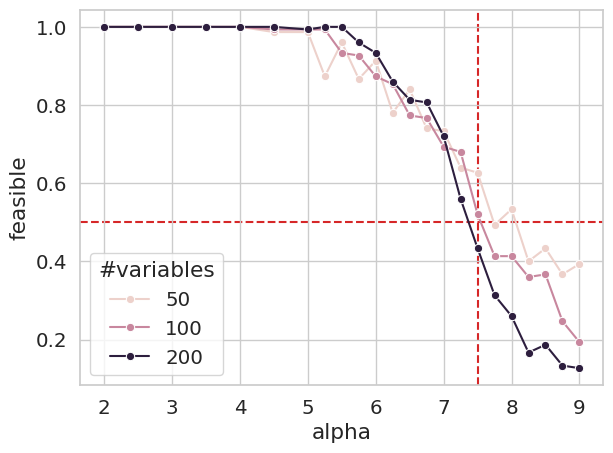

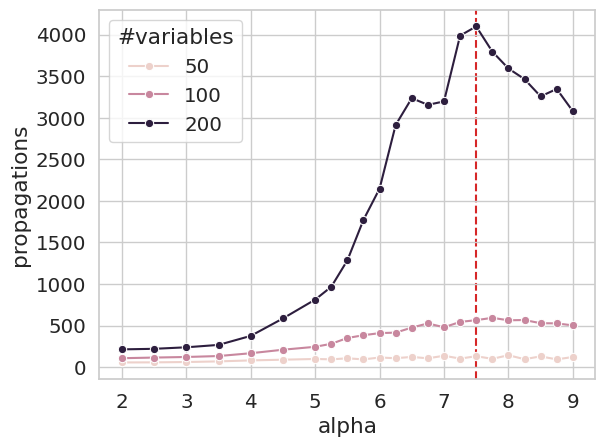

In [40]:
eval_results = top1.evaluation
eval_results = eval_results[eval_results["num_sampled_pairs"] == 100000]
eval_results = eval_results.groupby(["episode", "alpha", "num_vars", "solver"]).mean().reset_index()
eval_results = eval_results[eval_results["solver"] == "PySAT(minisat22)"]
eval_results = eval_results[eval_results["episode"] > 0]
eval_results = eval_results.rename(columns={"num_vars": "#variables"})
sns.lineplot(eval_results, x="alpha", y="feasible", hue="#variables", marker='o')
plt.axhline(0.5, c='tab:red', ls='--', zorder=-1000)
plt.axvline(7.5, c='tab:red', ls='--', zorder=-1000)
plt.tight_layout()
savefig("figs/9_critical_feasibility")
plt.show()

sns.lineplot(eval_results, x="alpha", y="propagations", hue="#variables", marker='o')
plt.axvline(7.5, c='tab:red', ls='--', zorder=-1000)
savefig("figs/9_critical_propagations")


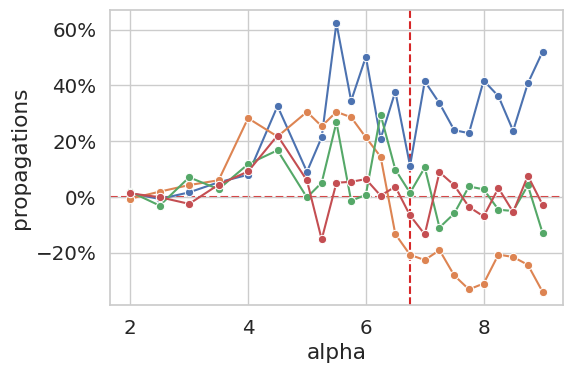

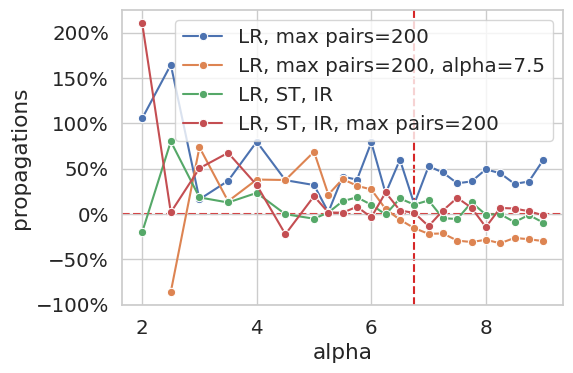

In [10]:
for solver in ["minisat22", "cadical153"]:
    r = []
    for name, exp in best_x.items():
        eval_results = exp.evaluation
        best_episode = eval_results["episode"].max()

        eval_results = eval_results[eval_results["num_sampled_pairs"] == 100000]
        eval_results = eval_results[eval_results["num_vars"] == 200]
        eval_results = eval_results.groupby(["episode", "alpha", "num_vars", "solver"]).mean()
        eval_results = eval_results.loc[best_episode] / eval_results.loc[0] - 1
        eval_results = eval_results.reset_index()
        eval_results = eval_results[eval_results["solver"] == f"PySAT({solver})"]
        
        eval_results["exp"] = name
        r.append(eval_results)
        
    plt.figure(figsize=(6,4))
    ax = sns.lineplot(pd.concat(r, ignore_index=True), x="alpha", y="propagations", hue="exp", marker='o')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    if solver == "minisat22":
        ax.get_legend().remove()
    else:
        ax.get_legend().set_title("")
        # sns.move_legend(plt.gca(), loc="upper right", bbox_to_anchor=(1.1, 1.1))
    # plt.ylim(, 4500)
    plt.axhline(0.00, c='tab:red', ls='--', zorder=-1000)
    plt.axvline(6.75, c='tab:red', ls='--', zorder=-1000)
    plt.tight_layout()
    savefig(f"figs/9_improvement_{solver}")
    plt.show()


## 10. Instance Augmentation

In [12]:
# s18
with pd.option_context('display.multi_sparse', False, 'display.precision', 5):
    display(results.sort_values("propagations_large")[["propagations", "propagations_at_ep", "propagations_large", "propagations_large_at_ep", "complex420", "complex420_splits", "complex625", "complex625_splits"]])


propagations  \
session name                                                               
14      defaults, lr=1e-5                                          85.25   
17      num_sampled_pairs=200, lr=2e-5(0.9999), complex...         82.96   
14      defaults, lr=2e-5(0.9999)                                  82.28   
17      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7...         83.39   
14      single_template, int_rewards, lr=1e-5                      83.77   
14      defaults, lr=1e-5(0.9999)                                  83.66   
14      num_sampled_pairs=200, lr=1e-5                             86.59   
14      num_sampled_pairs=200, lr=2e-5(0.9999)                     84.89   
14      single_template, int_rewards, num_sampled_pairs...         86.95   
17      num_sampled_pairs=200, lr=2e-5(0.9999), complex...         83.99   
16      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5          85.02   
17      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7...         84.95   
14      single_template, int_rewards, lr=2e-5(0.9999)              85.81   
14      single_template, int_rewards, num_sampled_pairs...         83.26   

                                                            propagations_at_ep  \
session name                                                                     
14      defaults, lr=1e-5                                                 8000   
17      num_sampled_pairs=200, lr=2e-5(0.9999), complex...               23000   
14      defaults, lr=2e-5(0.9999)                                         4750   
17      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7...               27000   
14      single_template, int_rewards, lr=1e-5                             6750   
14      defaults, lr=1e-5(0.9999)                                        12750   
14      num_sampled_pairs=200, lr=1e-5                                    3250   
14      num_sampled_pairs=200, lr=2e-5(0.9999)                            8250   
14      single_template, int_rewards, num_sampled_pairs...               12000   
17      num_sampled_pairs=200, lr=2e-5(0.9999), complex...               18000   
16      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5                 8750   
17      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7...               28000   
14      single_template, int_rewards, lr=2e-5(0.9999)                    12750   
14      single_template, int_rewards, num_sampled_pairs...                4500   

                                                            propagations_large  \
session name                                                                     
14      defaults, lr=1e-5                                               193.32   
17      num_sampled_pairs=200, lr=2e-5(0.9999), complex...              195.45   
14      defaults, lr=2e-5(0.9999)                                       198.24   
17      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7...              200.04   
14      single_template, int_rewards, lr=1e-5                           200.19   
14      defaults, lr=1e-5(0.9999)                                       201.34   
14      num_sampled_pairs=200, lr=1e-5                                  202.97   
14      num_sampled_pairs=200, lr=2e-5(0.9999)                          205.23   
14      single_template, int_rewards, num_sampled_pairs...              206.01   
17      num_sampled_pairs=200, lr=2e-5(0.9999), complex...              206.22   
16      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5               207.11   
17      num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7...              207.62   
14      single_template, int_rewards, lr=2e-5(0.9999)                   210.03   
14      single_template, int_rewards, num_sampled_pairs...              210.37   

                                                            propagations_large_at_ep  \
session name                                                                           
14      defaults, lr=1e-5                

In [39]:
print(results[["propagations", "propagations_large", "complex420", "complex625"]].dropna().to_latex())


\begin{tabular}{llrrrr}
\toprule
 &  & propagations & propagations_large & complex420 & complex625 \\
session & name &  &  &  &  \\
\midrule
14 & single_template, int_rewards, num_sampled_pairs=200, lr=2e-5(0.9999) & 83.260000 & 210.370000 & 1.000793 & 1.002977 \\
\cline{1-6}
16 & num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5 & 85.020000 & 207.110000 & 1.007658 & 1.013006 \\
\cline{1-6}
\multirow[t]{4}{*}{17} & num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-0.25 & 83.390000 & 200.040000 & 1.025020 & 1.004426 \\
 & num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-1 & 84.950000 & 207.620000 & 1.025210 & 1.015787 \\
 & num_sampled_pairs=200, lr=2e-5(0.9999), complexify=0-0.25 & 82.960000 & 195.450000 & 1.028044 & 1.006455 \\
 & num_sampled_pairs=200, lr=2e-5(0.9999), complexify=0-1 & 83.990000 & 206.220000 & 1.027196 & 1.006139 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [40]:
s17["num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-1"].directory.resolve()


PosixPath('/mnt/store/work/cs/stages/dauphine/hard_instances/lamgate/runs_raw/SAGE/2023-10-11T22:41:32')

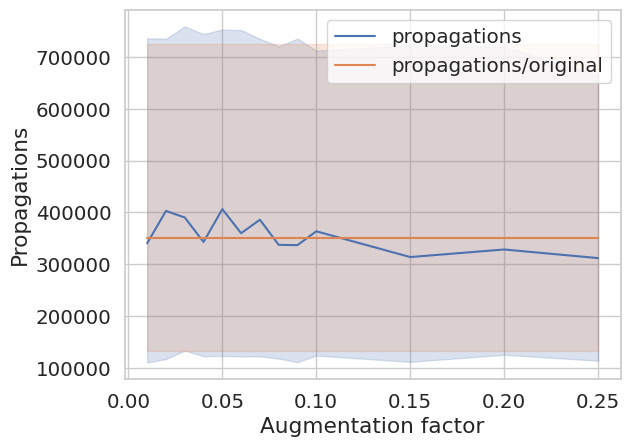

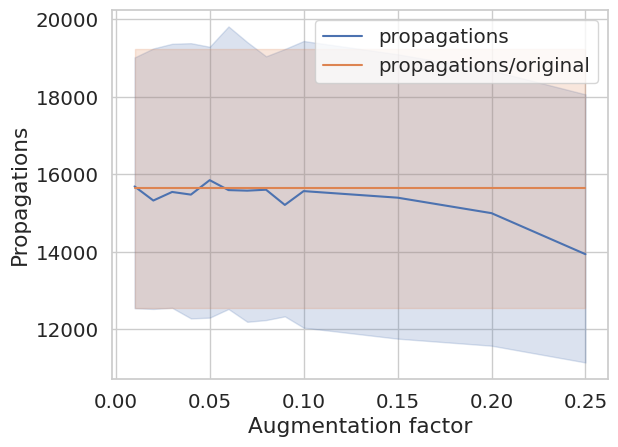

In [41]:
complexify = pd.read_parquet("../lamgate/runs/SAGE/s18 (num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-0.25)/complexify.parquet")
# complexify = pd.read_parquet("../lamgate/runs/SAGE/s18 (num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-1)/complexify.parquet")
molten = complexify.melt(id_vars=["num_vars", "alpha", "percent_split", "solver", "num_sampled_pairs", "run", "episode"], value_vars=["propagations", "propagations/original"], var_name="")

mask = (molten["solver"] == "PySAT(minisat22)") & (molten["num_vars"] == 200) & ((molten["alpha"] == 4.2))
sns.lineplot(x="percent_split", y="value", hue="", data=molten[mask], estimator=lambda x: np.median(x), errorbar=("pi", 50))
plt.xlabel("Augmentation factor")
plt.ylabel("Propagations")
savefig("figs/10_augmentation_minisat22")
plt.show()


mask2 = (molten["solver"] == "PySAT(minisat22)") & (molten["num_vars"] == 200) & ((molten["alpha"] == 6.75))
sns.lineplot(x="percent_split", y="value", hue="", data=molten[mask2], estimator=lambda x: np.median(x), errorbar=("pi", 50))
plt.xlabel("Augmentation factor")
plt.ylabel("Propagations")
savefig("figs/10_augmentation_cadical153")


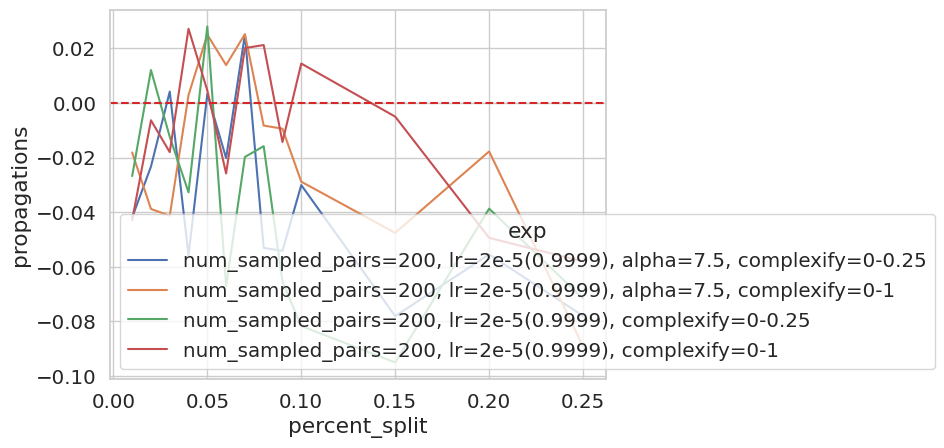

In [11]:
r = []
for name, exp in s17.items():
    complexify = pd.read_parquet(exp.directory / "complexify.parquet")
    assert complexify["episode"].unique().shape == (1,)
    assert complexify["num_vars"].unique().shape == (1,)
    assert complexify["num_sampled_pairs"].unique().shape == (1,)
    c = complexify.drop(["episode", "num_vars", "num_sampled_pairs"], axis=1)
    c = c.groupby(["alpha", "percent_split", "solver"]).mean()
    c = c.xs("PySAT(minisat22)", level="solver")
    c["propagations"] = c["propagations"] / c["propagations/original"] - 1
    
    c["exp"] = name
    r.append(c.reset_index())

r = pd.concat(r, ignore_index=True)
sns.lineplot(r[r["alpha"] == 4.2], x="percent_split", y="propagations", hue="exp")
plt.axhline(0.0, c="tab:red", ls="--")
savefig("figs/10_augmentation_relative")


feasible  time_cpu  restarts  conflicts  decisions  \
solver                                                                  
PySAT(cadical153)   0.78125  1.012539  1.019355   1.102887   1.089304   
PySAT(minisat22)    0.78125  1.065382  1.108348   1.144803   1.130964   

                   propagations  num_vars  alpha  num_sampled_pairs  run  
solver                                                                    
PySAT(cadical153)      1.097689       1.0    1.0                1.0  1.0  
PySAT(minisat22)       1.141530       1.0    1.0                1.0  1.0

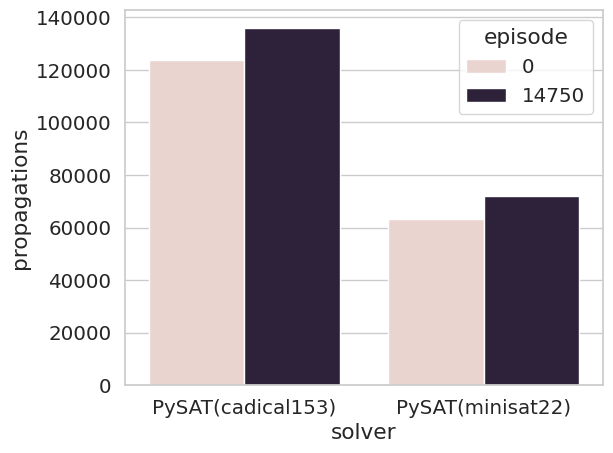

In [12]:
large_eval = pd.read_parquet("../lamgate/runs/SAGE/s14 (num_sampled_pairs=200, lr=2e-5(0.9999))/eval_large.parquet")
eval_results = large_eval.groupby(["episode", "solver"]).mean()
# eval_results = eval_results[eval_results["solver"] == "PySAT(minisat22)"]
sns.barplot(eval_results.reset_index(), x="solver", y="propagations", hue="episode", errorbar=("se", 1.0))
plt.tight_layout()
savefig("figs/11_final_eval")

relative_results = eval_results.loc[14750] / eval_results.loc[0]
relative_results


In [14]:
complexify


feasible  time_cpu  restarts  conflicts  decisions  propagations  \
21362      True  0.035590        15       3122       3984        121381   
21363      True  0.241767       117       8609      10622        320387   
2138      False  0.040960        22       4174       5011        161181   
2139      False  0.116034       110       6415       7758        234997   
3181       True  0.195799        62      15933      19426        641202   
...         ...       ...       ...        ...        ...           ...   
15234     False  0.005761         0        533        572         14313   
7657      False  0.004632         6        648        788         19414   
7658      False  0.015925         5       1427       1565         39350   
9902      False  0.006881         7        965       1135         27368   
9903      False  0.013264         0       1195       1269         33249   

       feasible/original  time_cpu/original  restarts/original  \
21362               True           0.026843                 14   
21363               True           0.234084                235   
2138               False           0.040939                 28   
2139               False           0.128749                134   
3181                True           0.025680                 14   
...                  ...                ...                ...   
15234              False           0.008458                  0   
7657               False           0.002807                  3   
7658               False           0.012245                  0   
9902               False           0.004985                  6   
9903               False           0.014283                  1   

       conflicts/original  decisions/original  propagations/original  \
21362                2398                3034                  91714   
21363                8309               11626                 311246   
2138                 5043                6078                 191730   
2139                 7051                8647                 259846   
3181                 2221                2779                  88248   
...                   ...                 ...                    ...   
15234                 776                 818                  20462   
7657                  386                 454                  11503   
7658                 1037                1104                  29886   
9902                  710                 840                  20445   
9903                 1275                1370                  35422   

       num_vars  alpha  percent_split             solver  num_sampled_pairs  \
21362       200   4.20           0.01   PySAT(minisat22)             100000   
21363       200   4.20           0.01  PySAT(cadical153)             100000   
2138        200   4.20           0.01   PySAT(minisat22)             100000   
2139        200   4.20           0.01  PySAT(cadical153)             100000   
3181        200   4.20           0.01   PySAT(minisat22)             100000   
...         ...    ...            ...                ...                ...   
15234       200   6.75           0.25  PySAT(cadical153)             100000   
7657        200   6.75           0.25   PySAT(minisat22)             100000   
7658        200   6.75           0.25  PySAT(cadical153)             100000   
9902        200   6.75           0.25   PySAT(minisat22)             100000   
9903        200   6.75           0.25  PySAT(cadical153)             100000   

       run  episode  
21362    0    18000  
21363    0    18000  
2138     1    18000  
2139     1    18000  
3181     2    18000  
...    ...      ...  
15234  497    18000  
7657   498    18000  
7658   498    18000  
9902   499    18000  
9903   499    18000  

[26000 rows x 19 columns]

In [13]:
complexify["propagations/original"].mean()


240374.9045

In [45]:
small["propagations"].mean()


435.409

In [16]:
random_ksat


feasible  time_cpu  restarts  conflicts  decisions  propagations  \
169276      True  0.000030         1          0         30            51   
169277      True  0.000032         0          0          0             0   
34128       True  0.000027         1          1         37            55   
34129       True  0.000024         0          0          0             0   
18036       True  0.000030         1          0         29            51   
...          ...       ...       ...        ...        ...           ...   
164501     False  0.001095         0        114        120          2569   
173098     False  0.001028         2        158        180          3847   
173099     False  0.002869         0        274        289          6539   
117194     False  0.001944         3        291        354          7504   
117195     False  0.004914         0        480        504         11729   

        num_vars  alpha             solver  run  
169276        50    2.0   PySAT(minisat22)    0  
169277        50    2.0  PySAT(cadical153)    0  
34128         50    2.0   PySAT(minisat22)    1  
34129         50    2.0  PySAT(cadical153)    1  
18036         50    2.0   PySAT(minisat22)    2  
...          ...    ...                ...  ...  
164501       200    9.0  PySAT(cadical153)  997  
173098       200    9.0   PySAT(minisat22)  998  
173099       200    9.0  PySAT(cadical153)  998  
117194       200    9.0   PySAT(minisat22)  999  
117195       200    9.0  PySAT(cadical153)  999  

[174000 rows x 10 columns]

## Z. k-SAT

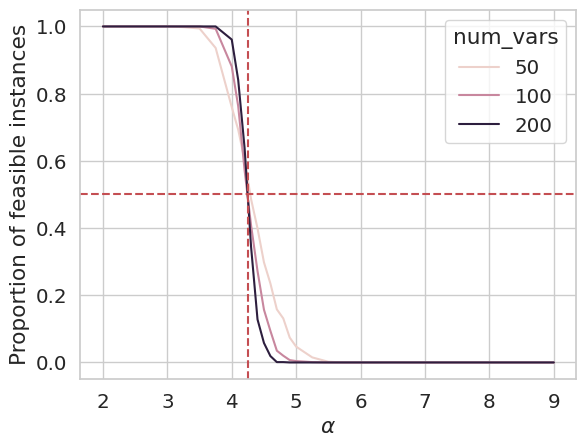

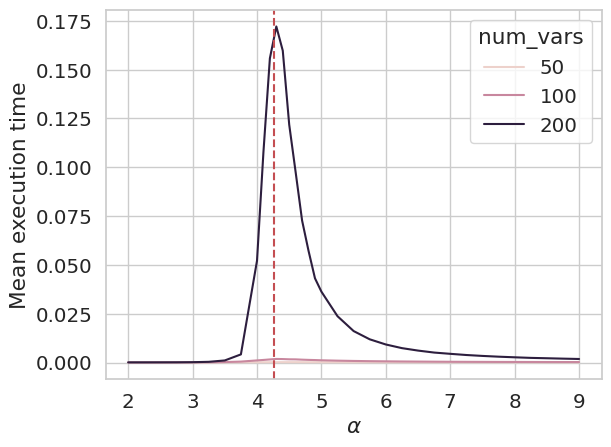

In [121]:
random_ksat = pd.read_parquet("../lamgate/runs/random_ksat_eval.parquet")

sns.lineplot(x="alpha", y="feasible", hue="num_vars", data=random_ksat[random_ksat["solver"] == "PySAT(minisat22)"].groupby(["alpha", "num_vars", "solver"]).mean(numeric_only=True))
plt.axhline(0.5, c='r', ls='--')
plt.axvline(4.26, c='r', ls='--')
plt.xlabel(r"$\alpha$")
plt.ylabel("Proportion of feasible instances")
savefig("figs/12_ksat_feasible")
plt.show()

sns.lineplot(x="alpha", y="time_cpu", hue="num_vars", data=random_ksat[random_ksat["solver"] == "PySAT(minisat22)"].groupby(["alpha", "num_vars"]).mean(numeric_only=True))
plt.axvline(4.26, c='r', ls='--')
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean execution time")
# plt.semilogy()
savefig("figs/12_ksat_time")



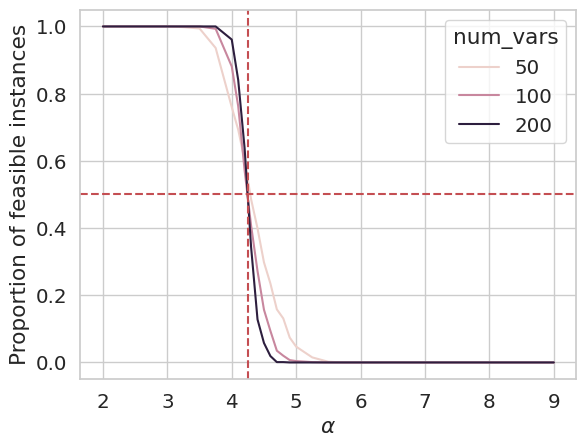

Text(0, 0.5, 'Mean execution time')

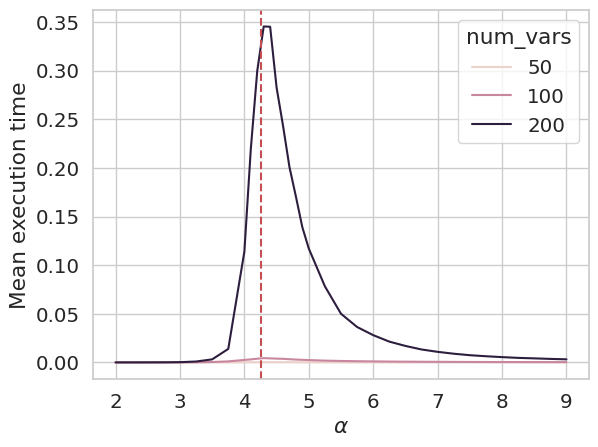

In [122]:
sns.lineplot(x="alpha", y="feasible", hue="num_vars", data=random_ksat[random_ksat["solver"] == "PySAT(cadical153)"].groupby(["alpha", "num_vars", "solver"]).mean(numeric_only=True))
plt.axhline(0.5, c='r', ls='--')
plt.axvline(4.26, c='r', ls='--')
plt.xlabel(r"$\alpha$")
plt.ylabel("Proportion of feasible instances")
# savefig("figs/12_ksat_feasible")
plt.show()

sns.lineplot(x="alpha", y="time_cpu", hue="num_vars", data=random_ksat[random_ksat["solver"] == "PySAT(cadical153)"].groupby(["alpha", "num_vars"]).mean(numeric_only=True))
plt.axvline(4.26, c='r', ls='--')
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean execution time")
# plt.semilogy()
# savefig("figs/12_ksat_time")


In [191]:
random_ksat[random_ksat["alpha"] == 4.3].groupby(["solver", "num_vars"])["propagations"].mean().reset_index()


solver  num_vars  propagations
0  PySAT(cadical153)        50       506.813
1  PySAT(cadical153)       100      8537.068
2  PySAT(cadical153)       200    470021.441
3   PySAT(minisat22)        50       458.573
4   PySAT(minisat22)       100      6211.206
5   PySAT(minisat22)       200    597040.683

In [185]:
# 2023-10-03T09:04:40-1
f = pd.read_parquet('../lamgate/runs/SAGE/s14 (single_template, int_rewards, num_sampled_pairs=200, lr=2e-5(0.9999))/train_eval_multinomial.parquet')

# 2023-10-09T09:41:28
# f = pd.read_parquet('../lamgate/runs/SAGE/s16 (num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5)/train_eval_multinomial.parquet')

# runs/SAGE/2023-10-11T22:41:32
# f = pd.read_parquet('../lamgate/runs/SAGE/s18 (num_sampled_pairs=200, lr=2e-5(0.9999), alpha=7.5, complexify=0-1)/train_eval_multinomial.parquet')

# 2023-10-11T22:41:32-3
# f = pd.read_parquet('../lamgate/runs/SAGE/s18 (num_sampled_pairs=200, lr=2e-5(0.9999), complexify=0-1)/train_eval_multinomial.parquet')


In [186]:
f[(f["episode"] > 0) & (f["solver"] == "PySAT(cadical153)")].groupby(["num_vars", "alpha"])["propagations"].mean().groupby("num_vars").max()


num_vars
50      456.820000
100    5889.533333
Name: propagations, dtype: float64

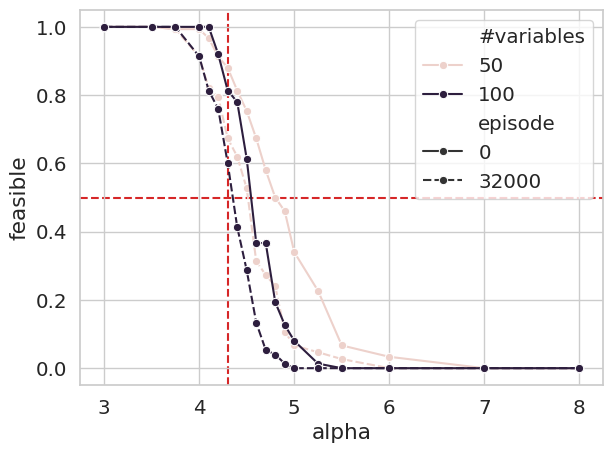

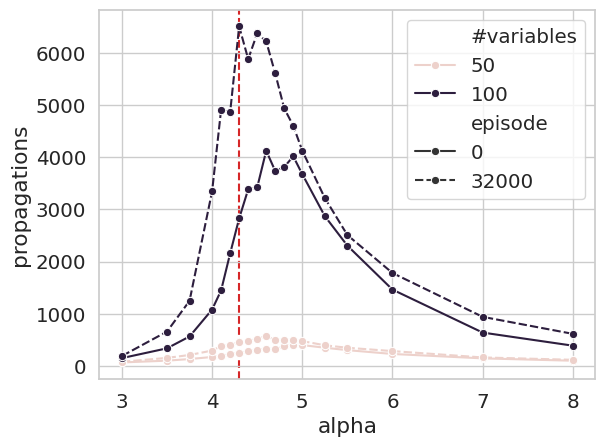

In [8]:
eval_results = f
eval_results = eval_results[eval_results["num_sampled_pairs"] == 100000]
eval_results = eval_results.groupby(["episode", "alpha", "num_vars", "solver"]).mean().reset_index()
eval_results = eval_results[eval_results["solver"] == "PySAT(minisat22)"]
eval_results = eval_results.rename(columns={"num_vars": "#variables"})
# eval_results = eval_results[eval_results["#variables"] < 200]
sns.lineplot(eval_results, x="alpha", y="feasible", hue="#variables", style="episode", marker='o')
plt.axhline(0.5, c='tab:red', ls='--', zorder=-1000)
plt.axvline(4.3, c='tab:red', ls='--', zorder=-1000)
plt.tight_layout()
# savefig("figs/9_critical_feasibility")
# plt.title(name)
plt.show()

sns.lineplot(eval_results, x="alpha", y="propagations", hue="#variables", style="episode", marker='o')
plt.axvline(4.3, c='tab:red', ls='--', zorder=-1000)
# savefig("figs/9_critical_propagations")
# plt.title(name)


In [157]:
# s__ = {
#     "A": load_history("../../runs_raw/SAGE/2023-10-24T04:29:19"),
#     "B": load_history("../../runs_raw/SAGE/2023-10-24T04:29:19-1"),
# }
s__ = {
    "no_int, large": load_history("../../runs_raw/SAGE/2023-10-25T07:27:19"),
    "no_int, small": load_history("../../runs_raw/SAGE/2023-10-25T07:27:19-1"),
    "int, small": load_history("../../runs_raw/SAGE/2023-10-25T07:27:19-2"),
    "int, large": load_history("../../runs_raw/SAGE/2023-10-25T07:27:19-3"),
    "lr, no_int, small": load_history("../../runs_raw/SAGE/2023-10-25T20:04:42"),
    "lr, int, small": load_history("../../runs_raw/SAGE/2023-10-25T20:04:42-1"),
    "lr, int, large": load_history("../../runs_raw/SAGE/2023-10-25T20:04:42-2"),
    "lr, no_int, large": load_history("../../runs_raw/SAGE/2023-10-25T20:04:42-3"),
}


Loaded history from 2023-10-25T07:27:19


Loaded history from 2023-10-25T07:27:19-1
Loaded history from 2023-10-25T07:27:19-2
Loaded history from 2023-10-25T07:27:19-3
Loaded history from 2023-10-25T20:04:42
Loaded history from 2023-10-25T20:04:42-1
Loaded history from 2023-10-25T20:04:42-2
Loaded history from 2023-10-25T20:04:42-3


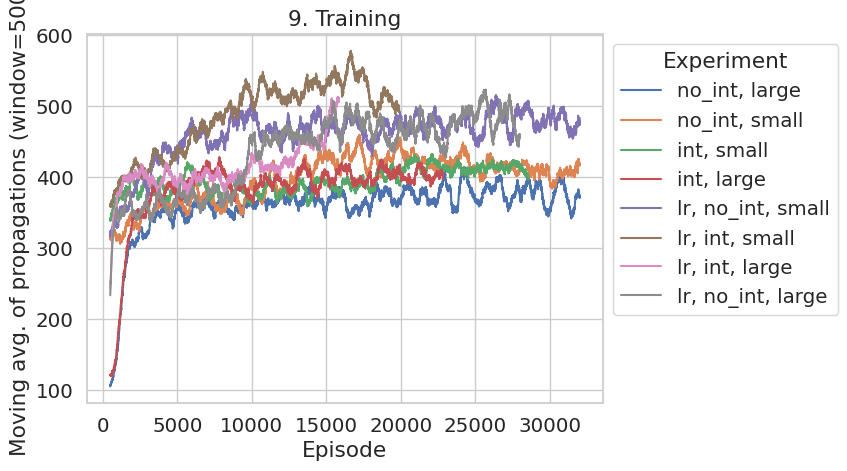

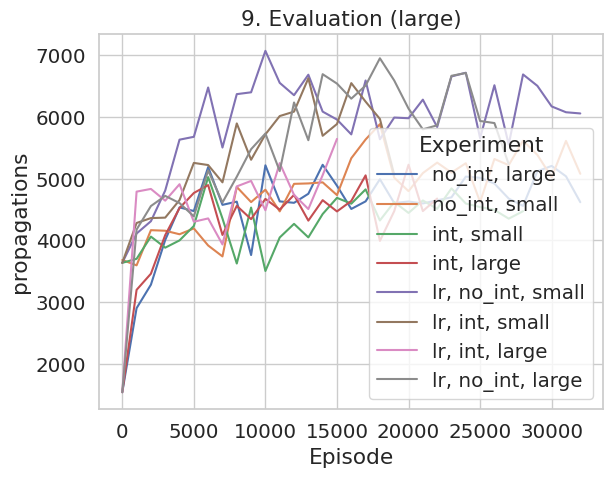

In [55]:
plot_metrics(
    s__,
    move_legend=True,
    window_size=500,
    metric="propagations",
    # saveto="figs/9_best_train",
    title="9. Training",
)

plot_metrics(
    s__,
    # move_legend=True,
    evaluation=True,
    template_size=630*2,
    window_size=1,
    metric="propagations",
    # saveto="figs/9_best_eval_large",
    title="9. Evaluation (large)",
)


In [189]:
results = []
for name, h in tqdm(s__.items()):
    r = {
        'name': name,
        'raw_path': h.directory.resolve().name,
    }
    episode_eval = h.episode.loc[h.episode.index.dropna()]
    sizes = episode_eval["template"].map(_template_size)

    episode_eval_large = episode_eval[sizes == 630*2]
    eval_scores_large = get_group(episode_eval_large, "metrics").groupby("episode").mean(numeric_only=True)
    props_large = eval_scores_large["propagations"]
    r['propagations100'] = props_large.max()
    r['propagations100_at_ep'] = props_large.idxmax()

    complexify_path = h.directory / "complexify.parquet"
    if complexify_path.exists():
        complexify = pd.read_parquet(complexify_path)
        molten = complexify.melt(id_vars=["num_vars", "alpha", "percent_split", "solver", "num_sampled_pairs", "run", "episode"], value_vars=["propagations", "propagations/original"])

        x = complexify.groupby(["solver", "num_vars", "alpha", "percent_split"]).mean(numeric_only=True)
        x = x.loc["PySAT(minisat22)", 100, 4.3]
        improvements = x["propagations"] / x["propagations/original"].values
        r['complex'] = improvements.max()
        r['complex_splits'] = improvements.idxmax()
    
    eval_path = h.directory / "eval_multinomial.parquet"
    if eval_path.exists():
        f = pd.read_parquet(eval_path)
        props = f.groupby(["num_vars", "alpha", "solver"])["propagations"].mean()
        opt_alpha = props.loc[50, :, "PySAT(minisat22)"].idxmax()
        r['propagations50'] = props.loc[50, opt_alpha, "PySAT(minisat22)"]
        r['propagations50_cadical'] = props.loc[50, opt_alpha, "PySAT(cadical153)"]
        
        if 200 in f["num_vars"].values:
            opt_alpha = props.loc[200, :, "PySAT(minisat22)"].idxmax()
            r['propagations200'] = props.loc[200, opt_alpha, "PySAT(minisat22)"]
            r['propagations200_cadical'] = props.loc[200, opt_alpha, "PySAT(cadical153)"]

    results.append(r)
results = pd.DataFrame(results).set_index(["name"], drop=True)
results = pd.concat(
    [
        results,
        pd.DataFrame([{"propagations50": 458.573, "propagations100": 6211.206, "propagations200": 597040.683, "propagations200_cadical": 470021.441}], index=["random k-SAT"])
    ]
)


  0%|          | 0/8 [00:00<?, ?it/s]

In [190]:
results.sort_values("propagations100")
# results.sort_values("raw_path")


raw_path  propagations100  \
int, small         2023-10-25T07:27:19-2         5027.120   
no_int, large        2023-10-25T07:27:19         5226.050   
int, large         2023-10-25T07:27:19-3         5227.610   
lr, int, large     2023-10-25T20:04:42-2         5645.480   
no_int, small      2023-10-25T07:27:19-1         5884.740   
random k-SAT                         NaN         6211.206   
lr, int, small     2023-10-25T20:04:42-1         6628.640   
lr, no_int, large  2023-10-25T20:04:42-3         6952.060   
lr, no_int, small    2023-10-25T20:04:42         7072.140   

                   propagations100_at_ep  propagations50  \
int, small                        6000.0      398.606667   
no_int, large                    14000.0      615.260000   
int, large                       20000.0      613.246667   
lr, int, large                   15000.0      561.340000   
no_int, small                    18000.0      418.180000   
random k-SAT                         NaN      458.573000   
lr, int, small                   13000.0      572.373333   
lr, no_int, large                18000.0      544.800000   
lr, no_int, small                10000.0      520.020000   

                   propagations50_cadical   complex  complex_splits  \
int, small                     413.973333       NaN             NaN   
no_int, large                  681.713333       NaN             NaN   
int, large                     621.953333       NaN             NaN   
lr, int, large                 594.980000       NaN             NaN   
no_int, small                  449.233333       NaN             NaN   
random k-SAT                          NaN       NaN             NaN   
lr, int, small                 649.820000       NaN             NaN   
lr, no_int, large              544.953333  1.004234            0.05   
lr, no_int, small              586.860000  0.999481            0.08   

                   propagations200  propagations200_cadical  
int, small                     NaN                      NaN  
no_int, large                  NaN                      NaN  
int, large                     NaN                      NaN  
lr, int, large                 NaN                      NaN  
no_int, small                  NaN                      NaN  
random k-SAT         597040.683000               470021.441  
lr, int, small                 NaN                      NaN  
lr, no_int, large    661552.953333               510951.800  
lr, no_int, small    719207.180000               521950.080

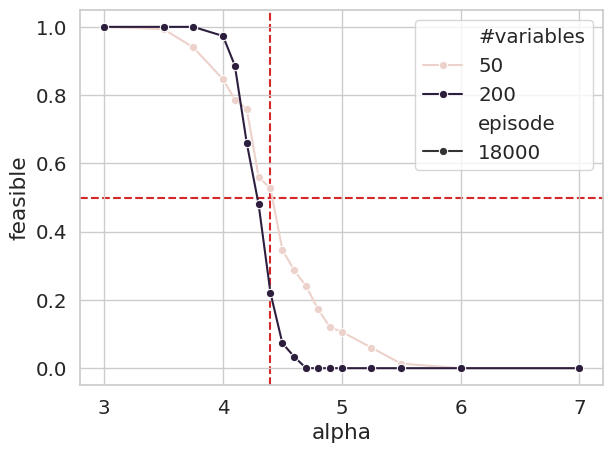

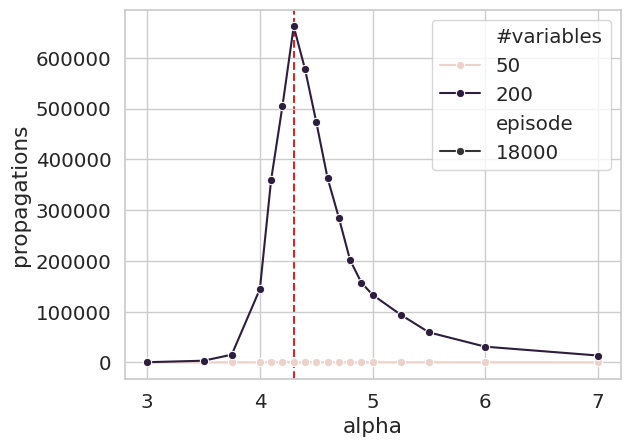

In [155]:
eval_results = pd.read_parquet('../lamgate/runs_raw/SAGE/2023-10-25T20:04:42-3/eval_multinomial.parquet')
eval_results = eval_results[eval_results["num_sampled_pairs"] == 100000]
eval_results = eval_results.groupby(["episode", "alpha", "num_vars", "solver"]).mean().reset_index()
eval_results = eval_results[eval_results["solver"] == "PySAT(minisat22)"]
eval_results = eval_results.rename(columns={"num_vars": "#variables"})
# eval_results = eval_results[eval_results["#variables"] < 200]
sns.lineplot(eval_results, x="alpha", y="feasible", hue="#variables", style="episode", marker='o')
plt.axhline(0.5, c='tab:red', ls='--', zorder=-1000)
plt.axvline(4.4, c='tab:red', ls='--', zorder=-1000)
plt.tight_layout()
# savefig("figs/9_critical_feasibility")
# plt.title(name)
plt.show()

sns.lineplot(eval_results, x="alpha", y="propagations", hue="#variables", style="episode", marker='o')
plt.axvline(4.3, c='tab:red', ls='--', zorder=-1000)
# savefig("figs/9_critical_propagations")
# plt.title(name)
